<a href="https://colab.research.google.com/github/ShaliniAnandaPhD/brain-electrode-compression/blob/main/Neuralink_Hybrid_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import logging
import zipfile

# Setting up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def extract_zip(zip_path, extract_to):
    logger.info(f"Checking if the file {zip_path} exists.")
    print(f"Checking if the file {zip_path} exists.")

    if not os.path.exists(zip_path):
        logger.error(f"Error: The file {zip_path} does not exist.")
        print(f"Error: The file {zip_path} does not exist.")
        return

    logger.info(f"File {zip_path} found. Attempting to extract to {extract_to}.")
    print(f"File {zip_path} found. Attempting to extract to {extract_to}.")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        logger.info(f"Extracted files from {zip_path} to {extract_to}")
        print(f"Extracted files from {zip_path} to {extract_to}")
    except Exception as e:
        logger.error(f"Error extracting {zip_path}: {e}")
        print(f"Error extracting {zip_path}: {e}")

# Example usage
zip_path = "/content/data (7).zip"
extract_to = "/content/extract/data"
extract_zip(zip_path, extract_to)

Checking if the file /content/data (7).zip exists.
File /content/data (7).zip found. Attempting to extract to /content/extract/data.
Extracted files from /content/data (7).zip to /content/extract/data


In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)


In [ ]:
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
def train_vae(model, dataloader, epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Example usage
file_path = '/content/extract/data/data/0052503c-2849-4f41-ab51-db382103690c.wav'
segment_size = 16000
latent_dim = 64
segments, samplerate = segment_audio(file_path, segment_size)

audio_dataset = AudioDataset(torch.tensor(segments, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=16, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader)
torch.save(model.state_dict(), 'vae_audio_compression.pth')


<ipython-input-6-48d705f3ab99>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments, dtype=torch.float32))


Epoch 1/50, Loss: 294.49550083705356
Epoch 2/50, Loss: 165.12332589285714
Epoch 3/50, Loss: 127.29849679129464
Epoch 4/50, Loss: 119.55400739397321
Epoch 5/50, Loss: 105.22586495535714
Epoch 6/50, Loss: 97.40621512276786
Epoch 7/50, Loss: 88.41456821986607
Epoch 8/50, Loss: 87.59205845424107
Epoch 9/50, Loss: 84.44011579241071
Epoch 10/50, Loss: 78.64393833705357
Epoch 11/50, Loss: 76.05914306640625
Epoch 12/50, Loss: 75.35258265904018
Epoch 13/50, Loss: 72.36632428850446
Epoch 14/50, Loss: 71.49408830915179
Epoch 15/50, Loss: 67.92845807756696
Epoch 16/50, Loss: 68.21002633231026
Epoch 17/50, Loss: 65.29247610909599
Epoch 18/50, Loss: 62.18072509765625
Epoch 19/50, Loss: 64.47630964006696
Epoch 20/50, Loss: 62.626961844308035
Epoch 21/50, Loss: 58.98409162248884
Epoch 22/50, Loss: 61.52964564732143
Epoch 23/50, Loss: 58.080601283482146
Epoch 24/50, Loss: 62.344247000558035
Epoch 25/50, Loss: 57.32141549246652
Epoch 26/50, Loss: 57.67088099888393
Epoch 27/50, Loss: 57.144461495535715
E

In [ ]:
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, logvar = model.encode(segment_tensor)
            z = model.reparameterize(mu, logvar)
            compressed_audio.append(z.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    np.save('compressed_audio.npy', compressed_audio)
    return 'compressed_audio.npy'

def decompress_audio(model, compressed_file, segment_size):
    compressed_audio = np.load(compressed_file)
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for z in compressed_audio:
            z_tensor = torch.tensor(z).float().unsqueeze(0)
            recon_segment = model.decode(z_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    sf.write('decompressed_audio.wav', decompressed_audio, samplerate)
    return 'decompressed_audio.wav'

compressed_file = compress_audio(model, segments)
print(f"Compressed file saved at: {compressed_file}")

decompressed_file = decompress_audio(model, compressed_file, segment_size)
print(f"Decompressed file saved at: {decompressed_file}")

def calculate_compression_ratio(original_file, compressed_file):
    original_size = os.path.getsize(original_file)
    compressed_size = os.path.getsize(compressed_file)
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size

compression_ratio, original_size, compressed_size = calculate_compression_ratio(file_path, compressed_file)
print(f"Compression Ratio: {compression_ratio}")
print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")


Compressed file saved at: compressed_audio.npy
Decompressed file saved at: decompressed_audio.wav
Compression Ratio: 102.82395833333334
Original Size: 197422 bytes
Compressed Size: 1920 bytes


In [ ]:
import os

def get_file_size(file_path):
    return os.path.getsize(file_path)

decompressed_file = "decompressed_audio.wav"  # Replace with your actual decompressed file path
decompressed_size = get_file_size(decompressed_file)
print(f"Decompressed Size: {decompressed_size} bytes")


Decompressed Size: 224044 bytes


In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the DiffusionModel using a more complex encoder-decoder architecture
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (segment_size // 8), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (segment_size // 8)),
            nn.ReLU(),
            nn.Unflatten(1, (128, segment_size // 8)),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def compress(self, x):
        with torch.no_grad():
            return self.encoder(x)

    def decompress(self, x):
        with torch.no_grad():
            return self.decoder(x)

# Train the model on the dataset
def train_model(model, dataloader, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataloader:
            data = data.unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader)}')

# Compress the audio segments using the trained model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    for segment in segments:
        segment_tensor = torch.tensor(segment).unsqueeze(0).unsqueeze(0).float()
        compressed_segment = model.compress(segment_tensor)
        compressed_audio.append(compressed_segment.squeeze().detach().numpy())
    compressed_audio = np.concatenate(compressed_audio)
    np.save('compressed_audio.npy', compressed_audio)
    return 'compressed_audio.npy'

# Decompress the audio using the trained model
def decompress_audio(model, compressed_file, segment_size, samplerate):
    compressed_audio = np.load(compressed_file)
    num_segments = compressed_audio.shape[0] // 128
    decompressed_audio = []
    model.eval()
    for i in range(num_segments):
        segment = compressed_audio[i * 128: (i + 1) * 128]
        segment_tensor = torch.tensor(segment).unsqueeze(0).float()
        decompressed_segment = model.decompress(segment_tensor)
        decompressed_audio.append(decompressed_segment.squeeze().detach().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    sf.write('decompressed_audio.wav', decompressed_audio, samplerate)
    return 'decompressed_audio.wav'

# Calculate compression ratio
def calculate_compression_ratio(original_file, compressed_file, decompressed_file):
    original_size = os.path.getsize(original_file)
    compressed_size = os.path.getsize(compressed_file)
    decompressed_size = os.path.getsize(decompressed_file)
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
file_path = '/content/extract/data/data/0052503c-2849-4f41-ab51-db382103690c.wav'
segment_size = 16000
segments, samplerate = segment_audio(file_path, segment_size)
print(f"Segmented {len(segments)} segments from audio.")

audio_dataset = AudioDataset(segments)
dataloader = DataLoader(audio_dataset, batch_size=8, shuffle=True)

model = DiffusionModel(latent_dim=128)
train_model(model, dataloader, epochs=100)

compressed_file = compress_audio(model, segments)
print(f"Compressed file saved at: {compressed_file}")

decompressed_file = decompress_audio(model, compressed_file, segment_size, samplerate)
print(f"Decompressed file saved at: {decompressed_file}")

compression_ratio, original_size, compressed_size, decompressed_size = calculate_compression_ratio(file_path, compressed_file, decompressed_file)
print(f"Compression Ratio: {compression_ratio}")
print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")
print(f"Decompressed Size: {decompressed_size} bytes")

Segmented 7 segments from audio.
Epoch 1/100, Loss: 0.5482562184333801
Epoch 2/100, Loss: 0.5414141416549683
Epoch 3/100, Loss: 0.5197783708572388
Epoch 4/100, Loss: 0.48855963349342346
Epoch 5/100, Loss: 0.469920814037323
Epoch 6/100, Loss: 0.45839712023735046
Epoch 7/100, Loss: 0.4379725158214569
Epoch 8/100, Loss: 0.412837952375412
Epoch 9/100, Loss: 0.39243045449256897
Epoch 10/100, Loss: 0.37725701928138733
Epoch 11/100, Loss: 0.35868358612060547
Epoch 12/100, Loss: 0.34077325463294983
Epoch 13/100, Loss: 0.3276621997356415
Epoch 14/100, Loss: 0.3128533661365509
Epoch 15/100, Loss: 0.29653865098953247
Epoch 16/100, Loss: 0.28350427746772766
Epoch 17/100, Loss: 0.2698383331298828
Epoch 18/100, Loss: 0.2561732828617096
Epoch 19/100, Loss: 0.24521470069885254
Epoch 20/100, Loss: 0.23305487632751465
Epoch 21/100, Loss: 0.22195042669773102
Epoch 22/100, Loss: 0.21171416342258453
Epoch 23/100, Loss: 0.20105284452438354
Epoch 24/100, Loss: 0.19194740056991577
Epoch 25/100, Loss: 0.182011

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the DiffusionModel using a more complex encoder-decoder architecture
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim=512):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (segment_size // 16), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * (segment_size // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (256, segment_size // 16)),
            nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def compress(self, x):
        with torch.no_grad():
            return self.encoder(x)

    def decompress(self, x):
        with torch.no_grad():
            return self.decoder(x)

# Train the model on the dataset
def train_model(model, dataloader, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for data in dataloader:
            data = data.unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader)}')

# Compress the audio segments using the trained model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    for segment in segments:
        segment_tensor = torch.tensor(segment).unsqueeze(0).unsqueeze(0).float()
        compressed_segment = model.compress(segment_tensor)
        compressed_audio.append(compressed_segment.squeeze().detach().numpy())
    compressed_audio = np.concatenate(compressed_audio)
    np.save('compressed_audio.npy', compressed_audio)
    return 'compressed_audio.npy'

# Decompress the audio using the trained model
def decompress_audio(model, compressed_file, segment_size, samplerate):
    compressed_audio = np.load(compressed_file)
    num_segments = compressed_audio.shape[0] // 512
    decompressed_audio = []
    model.eval()
    for i in range(num_segments):
        segment = compressed_audio[i * 512: (i + 1) * 512]
        segment_tensor = torch.tensor(segment).unsqueeze(0).float()
        decompressed_segment = model.decompress(segment_tensor)
        decompressed_audio.append(decompressed_segment.squeeze().detach().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    sf.write('decompressed_audio.wav', decompressed_audio, samplerate)
    return 'decompressed_audio.wav'

# Calculate compression ratio
def calculate_compression_ratio(original_file, compressed_file, decompressed_file):
    original_size = os.path.getsize(original_file)
    compressed_size = os.path.getsize(compressed_file)
    decompressed_size = os.path.getsize(decompressed_file)
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
file_path = '/content/extract/data/data/0052503c-2849-4f41-ab51-db382103690c.wav'
segment_size = 16000
segments, samplerate = segment_audio(file_path, segment_size)
print(f"Segmented {len(segments)} segments from audio.")

audio_dataset = AudioDataset(segments)
dataloader = DataLoader(audio_dataset, batch_size=8, shuffle=True)

model = DiffusionModel(latent_dim=512)
train_model(model, dataloader, epochs=200)

compressed_file = compress_audio(model, segments)
print(f"Compressed file saved at: {compressed_file}")

decompressed_file = decompress_audio(model, compressed_file, segment_size, samplerate)
print(f"Decompressed file saved at: {decompressed_file}")

compression_ratio, original_size, compressed_size, decompressed_size = calculate_compression_ratio(file_path, compressed_file, decompressed_file)
print(f"Compression Ratio: {compression_ratio}")
print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")
print(f"Decompressed Size: {decompressed_size} bytes")

Segmented 7 segments from audio.
Epoch 1/200, Loss: 0.430774062871933
Epoch 2/200, Loss: 0.42782896757125854
Epoch 3/200, Loss: 0.42093706130981445
Epoch 4/200, Loss: 0.41108235716819763
Epoch 5/200, Loss: 0.39700546860694885
Epoch 6/200, Loss: 0.37742263078689575
Epoch 7/200, Loss: 0.35136550664901733
Epoch 8/200, Loss: 0.32034832239151
Epoch 9/200, Loss: 0.29578325152397156
Epoch 10/200, Loss: 0.28928279876708984
Epoch 11/200, Loss: 0.2790583074092865
Epoch 12/200, Loss: 0.2566772699356079
Epoch 13/200, Loss: 0.23308424651622772
Epoch 14/200, Loss: 0.21904893219470978
Epoch 15/200, Loss: 0.2097722738981247
Epoch 16/200, Loss: 0.19706353545188904
Epoch 17/200, Loss: 0.18179993331432343
Epoch 18/200, Loss: 0.16963745653629303
Epoch 19/200, Loss: 0.16056549549102783
Epoch 20/200, Loss: 0.14928223192691803
Epoch 21/200, Loss: 0.13667428493499756
Epoch 22/200, Loss: 0.12708409130573273
Epoch 23/200, Loss: 0.11927232891321182
Epoch 24/200, Loss: 0.11070089042186737
Epoch 25/200, Loss: 0.10

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, logvar = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    np.save('compressed_audio.npy', compressed_audio)
    return 'compressed_audio.npy'

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_file, segment_size):
    compressed_audio = np.load(compressed_file)
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    sf.write('decompressed_audio.wav', decompressed_audio, samplerate)
    return 'decompressed_audio.wav'

# Calculate compression ratio
def calculate_compression_ratio(original_file, compressed_file):
    original_size = os.path.getsize(original_file)
    compressed_size = os.path.getsize(compressed_file)
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size

# Example usage
file_path = '/content/extract/data/data/0052503c-2849-4f41-ab51-db382103690c.wav'
segment_size = 16000
latent_dim = 32
segments, samplerate = segment_audio(file_path, segment_size)

audio_dataset = AudioDataset(torch.tensor(segments, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=32, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader)
torch.save(model.state_dict(), 'vae_audio_compression.pth')

compressed_file = compress_audio(model, segments)
print(f"Compressed file saved at: {compressed_file}")

decompressed_file = decompress_audio(model, compressed_file, segment_size)
print(f"Decompressed file saved at: {decompressed_file}")

compression_ratio, original_size, compressed_size = calculate_compression_ratio(file_path, compressed_file)
print(f"Compression Ratio: {compression_ratio}")
print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")

Epoch 1/100, Loss: 232.39226422991072
Epoch 2/100, Loss: 141.45420619419642
Epoch 3/100, Loss: 102.64286586216518
Epoch 4/100, Loss: 87.77606201171875
Epoch 5/100, Loss: 78.46515764508929
Epoch 6/100, Loss: 72.4472176688058
Epoch 7/100, Loss: 69.56671578543526
Epoch 8/100, Loss: 67.84849766322544
Epoch 9/100, Loss: 68.14189801897321
Epoch 10/100, Loss: 64.82291957310268
Epoch 11/100, Loss: 64.32608904157367
Epoch 12/100, Loss: 62.50883265904018
Epoch 13/100, Loss: 61.32954624720982
Epoch 14/100, Loss: 59.443882533482146
Epoch 15/100, Loss: 58.42728533063616
Epoch 16/100, Loss: 56.734200613839285
Epoch 17/100, Loss: 55.609043666294646
Epoch 18/100, Loss: 55.193455287388396
Epoch 19/100, Loss: 53.72247750418527
Epoch 20/100, Loss: 53.14359392438616
Epoch 21/100, Loss: 51.953033447265625
Epoch 22/100, Loss: 52.07658168247768
Epoch 23/100, Loss: 52.168653215680806
Epoch 24/100, Loss: 50.550040108816965
Epoch 25/100, Loss: 50.96689714704241
Epoch 26/100, Loss: 51.317884172712056
Epoch 27/10

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=150, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    np.save('compressed_audio.npy', compressed_audio)
    return 'compressed_audio.npy'

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_file, segment_size):
    compressed_audio = np.load(compressed_file)
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    sf.write('decompressed_audio.wav', decompressed_audio, samplerate)
    return 'decompressed_audio.wav'

# Calculate compression ratio
def calculate_compression_ratio(original_file, compressed_file):
    original_size = os.path.getsize(original_file)
    compressed_size = os.path.getsize(compressed_file)
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size

# Example usage
file_path = '/content/extract/data/data/0052503c-2849-4f41-ab51-db382103690c.wav'
segment_size = 16000
latent_dim = 16
segments, samplerate = segment_audio(file_path, segment_size)

audio_dataset = AudioDataset(torch.tensor(segments, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=150)
torch.save(model.state_dict(), 'vae_audio_compression.pth')

compressed_file = compress_audio(model, segments)
print(f"Compressed file saved at: {compressed_file}")

decompressed_file = decompress_audio(model, compressed_file, segment_size)
print(f"Decompressed file saved at: {decompressed_file}")

compression_ratio, original_size, compressed_size = calculate_compression_ratio(file_path, compressed_file)
print(f"Compression Ratio: {compression_ratio}")
print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")

Epoch 1/150, Loss: 94.13471330915179
Epoch 2/150, Loss: 59.350167410714285
Epoch 3/150, Loss: 56.16782488141741
Epoch 4/150, Loss: 53.03264944893973
Epoch 5/150, Loss: 50.23394339425223
Epoch 6/150, Loss: 47.71087210518973
Epoch 7/150, Loss: 47.953338623046875
Epoch 8/150, Loss: 45.261182512555806
Epoch 9/150, Loss: 46.35207257952009
Epoch 10/150, Loss: 45.66394478934152
Epoch 11/150, Loss: 41.758213588169646
Epoch 12/150, Loss: 44.045322963169646
Epoch 13/150, Loss: 41.016505650111604
Epoch 14/150, Loss: 38.924913678850444
Epoch 15/150, Loss: 37.294625418526785
Epoch 16/150, Loss: 34.243443080357146
Epoch 17/150, Loss: 32.76378958565848
Epoch 18/150, Loss: 35.58826337541853
Epoch 19/150, Loss: 41.056976318359375
Epoch 20/150, Loss: 31.11989484514509
Epoch 21/150, Loss: 28.99599347795759
Epoch 22/150, Loss: 32.29353550502232
Epoch 23/150, Loss: 36.859056745256694
Epoch 24/150, Loss: 28.667851039341517
Epoch 25/150, Loss: 29.841177804129465
Epoch 26/150, Loss: 24.123236519949778
Epoch 2

In [ ]:
import os

decompressed_file = "decompressed_audio.wav"  # Replace with the actual path to your decompressed file
decompressed_size = os.path.getsize(decompressed_file)
print(f"Decompressed Size: {decompressed_size} bytes")

Decompressed Size: 224044 bytes


In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=150, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=150)
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")

Epoch 1/150, Loss: 83.22077200753348
Epoch 2/150, Loss: 53.67347041538783
Epoch 3/150, Loss: 51.15223737444197
Epoch 4/150, Loss: 48.52156459263393
Epoch 5/150, Loss: 47.051413835797995
Epoch 6/150, Loss: 45.234648786272324
Epoch 7/150, Loss: 44.29363664899554
Epoch 8/150, Loss: 43.60251552036831
Epoch 9/150, Loss: 43.611166163853234
Epoch 10/150, Loss: 43.20435289655413
Epoch 11/150, Loss: 43.10818873814174
Epoch 12/150, Loss: 42.31236092703683
Epoch 13/150, Loss: 42.95269274030413
Epoch 14/150, Loss: 43.13919285365513
Epoch 15/150, Loss: 42.27637874058315
Epoch 16/150, Loss: 41.521837506975444
Epoch 17/150, Loss: 43.02965785435268
Epoch 18/150, Loss: 40.64493451799665
Epoch 19/150, Loss: 41.835335867745535
Epoch 20/150, Loss: 40.94743434361049
Epoch 21/150, Loss: 40.130675833565846
Epoch 22/150, Loss: 41.677622767857144
Epoch 23/150, Loss: 39.971274675641745
Epoch 24/150, Loss: 41.47191946847098
Epoch 25/150, Loss: 40.49226422991072
Epoch 26/150, Loss: 39.94860556466239
Epoch 27/150,

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=150, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 32  # Increased latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=150)
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")

Epoch 1/150, Loss: 81.97772173200335
Epoch 2/150, Loss: 53.419505092075894
Epoch 3/150, Loss: 50.47959224155971
Epoch 4/150, Loss: 48.16161106654576
Epoch 5/150, Loss: 46.58521096365792
Epoch 6/150, Loss: 45.01881583077567
Epoch 7/150, Loss: 44.207791573660714
Epoch 8/150, Loss: 43.951594543457034
Epoch 9/150, Loss: 43.58040422712054
Epoch 10/150, Loss: 43.53856157575335
Epoch 11/150, Loss: 43.06118469238281
Epoch 12/150, Loss: 43.201321847098214
Epoch 13/150, Loss: 42.73326394217355
Epoch 14/150, Loss: 42.377579607282364
Epoch 15/150, Loss: 41.9997567313058
Epoch 16/150, Loss: 42.3187731061663
Epoch 17/150, Loss: 42.316813005719865
Epoch 18/150, Loss: 42.35010419573103
Epoch 19/150, Loss: 41.112636021205354
Epoch 20/150, Loss: 41.3350339617048
Epoch 21/150, Loss: 41.416012573242185
Epoch 22/150, Loss: 40.70624128069196
Epoch 23/150, Loss: 41.611346871512275
Epoch 24/150, Loss: 40.324917384556365
Epoch 25/150, Loss: 40.94444274902344
Epoch 26/150, Loss: 41.053300040108816
Epoch 27/150,

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=150, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 32  # Increased latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=150)
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/150, Loss: 81.97772173200335
Epoch 2/150, Loss: 53.419505092075894
Epoch 3/150, Loss: 50.47959224155971
Epoch 4/150, Loss: 48.16161106654576
Epoch 5/150, Loss: 46.58521096365792
Epoch 6/150, Loss: 45.01881583077567
Epoch 7/150, Loss: 44.207791573660714
Epoch 8/150, Loss: 43.951594543457034
Epoch 9/150, Loss: 43.58040422712054
Epoch 10/150, Loss: 43.53856157575335
Epoch 11/150, Loss: 43.06118469238281
Epoch 12/150, Loss: 43.201321847098214
Epoch 13/150, Loss: 42.73326394217355
Epoch 14/150, Loss: 42.377579607282364
Epoch 15/150, Loss: 41.9997567313058
Epoch 16/150, Loss: 42.3187731061663
Epoch 17/150, Loss: 42.316813005719865
Epoch 18/150, Loss: 42.35010419573103
Epoch 19/150, Loss: 41.112636021205354
Epoch 20/150, Loss: 41.3350339617048
Epoch 21/150, Loss: 41.416012573242185
Epoch 22/150, Loss: 40.70624128069196
Epoch 23/150, Loss: 41.611346871512275
Epoch 24/150, Loss: 40.324917384556365
Epoch 25/150, Loss: 40.94444274902344
Epoch 26/150, Loss: 41.053300040108816
Epoch 27/150,

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the Enhanced VAE architecture
class EnhancedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(EnhancedVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048),  # Increased layer size
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=150, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio

# Simple smoothing filter as an example of post-processing
def post_process_audio(audio):
    smoothed_audio = np.convolve(audio, np.ones(10)/10, mode='same')
    return smoothed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 32  # Increased latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = EnhancedVAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=150)
torch.save(model.state_dict(), 'enhanced_vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)
        decompressed_audio = post_process_audio(decompressed_audio)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/150, Loss: 81.2493879045759
Epoch 2/150, Loss: 53.01396222795759
Epoch 3/150, Loss: 48.56834019252232
Epoch 4/150, Loss: 45.54479740687779
Epoch 5/150, Loss: 44.31326184953962
Epoch 6/150, Loss: 43.619537353515625
Epoch 7/150, Loss: 42.62078072684152
Epoch 8/150, Loss: 42.308226231166294
Epoch 9/150, Loss: 42.33111746651786
Epoch 10/150, Loss: 43.097186715262275
Epoch 11/150, Loss: 49.473583984375
Epoch 12/150, Loss: 45.004210117885044
Epoch 13/150, Loss: 46.81080496651786
Epoch 14/150, Loss: 45.20994742257255
Epoch 15/150, Loss: 43.59543151855469
Epoch 16/150, Loss: 44.3490968976702
Epoch 17/150, Loss: 43.76319754464286
Epoch 18/150, Loss: 42.98423113141741
Epoch 19/150, Loss: 42.77614048549107
Epoch 20/150, Loss: 42.13714120047433
Epoch 21/150, Loss: 41.04917362758091
Epoch 22/150, Loss: 41.362569972446984
Epoch 23/150, Loss: 40.98911808558873
Epoch 24/150, Loss: 40.855780029296874
Epoch 25/150, Loss: 40.15619986397879
Epoch 26/150, Loss: 40.514521789550784
Epoch 27/150, Loss

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=50, lr=1e-3):  # Reduced number of epochs for faster training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size*len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Adjusted latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=50)  # Reduced epochs for faster iteration
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/50, Loss: 226.37835780552456
Epoch 2/50, Loss: 89.88978358677456
Epoch 3/50, Loss: 71.37078247070312
Epoch 4/50, Loss: 66.35521109444754
Epoch 5/50, Loss: 63.972929164341515
Epoch 6/50, Loss: 61.575603812081475
Epoch 7/50, Loss: 58.948781912667414
Epoch 8/50, Loss: 56.589305768694196
Epoch 9/50, Loss: 54.521219744001115
Epoch 10/50, Loss: 53.084572492327005
Epoch 11/50, Loss: 51.71185041155134
Epoch 12/50, Loss: 50.54203578404018
Epoch 13/50, Loss: 49.97881164550781
Epoch 14/50, Loss: 48.91895926339286
Epoch 15/50, Loss: 47.57809927804129
Epoch 16/50, Loss: 46.659909057617185
Epoch 17/50, Loss: 46.521332441057474
Epoch 18/50, Loss: 46.31298304966518
Epoch 19/50, Loss: 45.2691159929548
Epoch 20/50, Loss: 45.126188441685265
Epoch 21/50, Loss: 44.101463535853796
Epoch 22/50, Loss: 44.12227172851563
Epoch 23/50, Loss: 43.92032427106585
Epoch 24/50, Loss: 43.55442853655134
Epoch 25/50, Loss: 42.939412580217635
Epoch 26/50, Loss: 43.05608738490513
Epoch 27/50, Loss: 43.02822549002511

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=50, lr=1e-3):  # Reduced number of epochs for faster training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Adjusted latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=50)  # Reduced epochs for faster iteration
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/50, Loss: 226.37835780552456
Epoch 2/50, Loss: 89.88978358677456
Epoch 3/50, Loss: 71.37078247070312
Epoch 4/50, Loss: 66.35521109444754
Epoch 5/50, Loss: 63.972929164341515
Epoch 6/50, Loss: 61.575603812081475
Epoch 7/50, Loss: 58.948781912667414
Epoch 8/50, Loss: 56.589305768694196
Epoch 9/50, Loss: 54.521219744001115
Epoch 10/50, Loss: 53.084572492327005
Epoch 11/50, Loss: 51.71185041155134
Epoch 12/50, Loss: 50.54203578404018
Epoch 13/50, Loss: 49.97881164550781
Epoch 14/50, Loss: 48.91895926339286
Epoch 15/50, Loss: 47.57809927804129
Epoch 16/50, Loss: 46.659909057617185
Epoch 17/50, Loss: 46.521332441057474
Epoch 18/50, Loss: 46.31298304966518
Epoch 19/50, Loss: 45.2691159929548
Epoch 20/50, Loss: 45.126188441685265
Epoch 21/50, Loss: 44.101463535853796
Epoch 22/50, Loss: 44.12227172851563
Epoch 23/50, Loss: 43.92032427106585
Epoch 24/50, Loss: 43.55442853655134
Epoch 25/50, Loss: 42.939412580217635
Epoch 26/50, Loss: 43.05608738490513
Epoch 27/50, Loss: 43.02822549002511

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture with reduced latent dimension
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):  # Increased epochs for better training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 8  # Further reduced latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=100)  # Increased epochs for better training
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 216.26663905552456
Epoch 2/100, Loss: 118.10814034598214
Epoch 3/100, Loss: 92.27236066545758
Epoch 4/100, Loss: 76.33518415178571
Epoch 5/100, Loss: 70.83368094308035
Epoch 6/100, Loss: 65.93616027832032
Epoch 7/100, Loss: 63.9551513671875
Epoch 8/100, Loss: 61.35997532435826
Epoch 9/100, Loss: 58.76000191824777
Epoch 10/100, Loss: 56.72219543457031
Epoch 11/100, Loss: 55.00829162597656
Epoch 12/100, Loss: 53.68442470005581
Epoch 13/100, Loss: 51.785223606654576
Epoch 14/100, Loss: 50.90017220633371
Epoch 15/100, Loss: 49.49507795061384
Epoch 16/100, Loss: 49.248333304268975
Epoch 17/100, Loss: 48.79711085728237
Epoch 18/100, Loss: 47.78721923828125
Epoch 19/100, Loss: 47.29839412144252
Epoch 20/100, Loss: 46.60527823311942
Epoch 21/100, Loss: 46.991571044921876
Epoch 22/100, Loss: 46.21376015799386
Epoch 23/100, Loss: 45.73377729143415
Epoch 24/100, Loss: 45.852657427106585
Epoch 25/100, Loss: 45.25327671595982
Epoch 26/100, Loss: 45.16443721226283
Epoch 27/100, Lo

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture with reduced latent dimension
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):  # Increased epochs for better training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 4  # Further reduced latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=100)  # Increased epochs for better training
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 236.34275861467634
Epoch 2/100, Loss: 122.55186593191964
Epoch 3/100, Loss: 84.19675728934152
Epoch 4/100, Loss: 73.39354684012277
Epoch 5/100, Loss: 67.8712655203683
Epoch 6/100, Loss: 64.11606052943638
Epoch 7/100, Loss: 62.13411254882813
Epoch 8/100, Loss: 58.72011108398438
Epoch 9/100, Loss: 56.717022269112725
Epoch 10/100, Loss: 54.05396248953683
Epoch 11/100, Loss: 52.35595964704241
Epoch 12/100, Loss: 51.06402326311384
Epoch 13/100, Loss: 49.457245744977676
Epoch 14/100, Loss: 49.2648197719029
Epoch 15/100, Loss: 48.121871076311386
Epoch 16/100, Loss: 46.99514988490513
Epoch 17/100, Loss: 47.0193110874721
Epoch 18/100, Loss: 46.14898965018136
Epoch 19/100, Loss: 45.884388296944756
Epoch 20/100, Loss: 45.42723824637277
Epoch 21/100, Loss: 44.79796098981585
Epoch 22/100, Loss: 44.62898385184152
Epoch 23/100, Loss: 44.334549822126114
Epoch 24/100, Loss: 43.43371320452009
Epoch 25/100, Loss: 43.665431431361604
Epoch 26/100, Loss: 43.3763676234654
Epoch 27/100, Los

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture with reduced latent dimension
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):  # Increased epochs for better training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 8  # Further reduced latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=100)  # Increased epochs for better training
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 222.7576407296317
Epoch 2/100, Loss: 94.20251770019532
Epoch 3/100, Loss: 69.20741969517299
Epoch 4/100, Loss: 63.12672816685268
Epoch 5/100, Loss: 61.21813136509487
Epoch 6/100, Loss: 59.02959354945592
Epoch 7/100, Loss: 57.295809500558036
Epoch 8/100, Loss: 54.97850734165737
Epoch 9/100, Loss: 52.16105433872768
Epoch 10/100, Loss: 50.2821783883231
Epoch 11/100, Loss: 48.94853341238839
Epoch 12/100, Loss: 48.12571890694755
Epoch 13/100, Loss: 47.07796151297433
Epoch 14/100, Loss: 46.56582990373884
Epoch 15/100, Loss: 46.05858394077846
Epoch 16/100, Loss: 45.31310860770089
Epoch 17/100, Loss: 44.65885489327567
Epoch 18/100, Loss: 44.299805995396206
Epoch 19/100, Loss: 44.41499502999442
Epoch 20/100, Loss: 43.537645612444194
Epoch 21/100, Loss: 43.18630763462612
Epoch 22/100, Loss: 43.17469460623605
Epoch 23/100, Loss: 42.571429879324775
Epoch 24/100, Loss: 42.69254629952567
Epoch 25/100, Loss: 42.3581296648298
Epoch 26/100, Loss: 41.73206394740513
Epoch 27/100, Loss:

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture with dropout and batch normalization
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function with perceptual loss
def perceptual_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):  # Increased epochs for better training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = perceptual_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 4  # Further reduced latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=100)  # Increased epochs for better training
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 1923.5901088169642
Epoch 2/100, Loss: 1255.142124720982
Epoch 3/100, Loss: 911.5997907366071
Epoch 4/100, Loss: 766.4569196428571
Epoch 5/100, Loss: 636.9539969308036
Epoch 6/100, Loss: 523.8559186662947
Epoch 7/100, Loss: 462.98351004464286
Epoch 8/100, Loss: 398.3168212890625
Epoch 9/100, Loss: 362.16442522321427
Epoch 10/100, Loss: 308.4765694754464
Epoch 11/100, Loss: 314.1330775669643
Epoch 12/100, Loss: 276.06680733816967
Epoch 13/100, Loss: 228.54622628348216
Epoch 14/100, Loss: 243.13221609933035
Epoch 15/100, Loss: 259.482235281808
Epoch 16/100, Loss: 167.98922816685268
Epoch 17/100, Loss: 191.43029610770088
Epoch 18/100, Loss: 183.12804129464286
Epoch 19/100, Loss: 158.9557861328125
Epoch 20/100, Loss: 162.05561872209822
Epoch 21/100, Loss: 131.0118408203125
Epoch 22/100, Loss: 133.66284702845982
Epoch 23/100, Loss: 158.41979457310268
Epoch 24/100, Loss: 131.29326520647322
Epoch 25/100, Loss: 156.55611397879466
Epoch 26/100, Loss: 120.22671944754464
Epoch 2

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture with dropout and batch normalization
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function with perceptual loss
def perceptual_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):  # Increased epochs for better training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = perceptual_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=100)  # Increased epochs for better training
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 1817.3159598214286
Epoch 2/100, Loss: 515.8810198102678
Epoch 3/100, Loss: 870.8301827566964
Epoch 4/100, Loss: 1379.917494419643
Epoch 5/100, Loss: 709.6032087053571
Epoch 6/100, Loss: 563.3001848493303
Epoch 7/100, Loss: 337.9981166294643
Epoch 8/100, Loss: 367.909610421317
Epoch 9/100, Loss: 252.63898577008928
Epoch 10/100, Loss: 205.15006103515626
Epoch 11/100, Loss: 249.17487444196428
Epoch 12/100, Loss: 209.1723127092634
Epoch 13/100, Loss: 178.44731794084822
Epoch 14/100, Loss: 179.20797642299107
Epoch 15/100, Loss: 141.1340619768415
Epoch 16/100, Loss: 130.71474609375
Epoch 17/100, Loss: 111.28048706054688
Epoch 18/100, Loss: 121.01178327287947
Epoch 19/100, Loss: 106.9599103655134
Epoch 20/100, Loss: 104.04686322893416
Epoch 21/100, Loss: 111.65987200055804
Epoch 22/100, Loss: 81.25606340680804
Epoch 23/100, Loss: 94.09024135044643
Epoch 24/100, Loss: 92.27479422433036
Epoch 25/100, Loss: 92.50000871930804
Epoch 26/100, Loss: 77.40033569335938
Epoch 27/100, 

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a simplified VAE architecture with dropout and batch normalization
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, latent_dim * 2)  # For mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function with perceptual loss
def perceptual_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Train the VAE model
def train_vae(model, dataloader, epochs=100, lr=1e-3):  # Increased epochs for better training
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = perceptual_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            mu, _ = model.encode(segment_tensor)
            compressed_audio.append(mu.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for mu in compressed_audio:
            mu_tensor = torch.tensor(mu).float().unsqueeze(0)
            recon_segment = model.decode(mu_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for better compression

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VAE(segment_size, latent_dim)
train_vae(model, dataloader, epochs=100)  # Increased epochs for better training
torch.save(model.state_dict(), 'vae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 1817.3159598214286
Epoch 2/100, Loss: 515.8810198102678
Epoch 3/100, Loss: 870.8301827566964
Epoch 4/100, Loss: 1379.917494419643
Epoch 5/100, Loss: 709.6032087053571
Epoch 6/100, Loss: 563.3001848493303
Epoch 7/100, Loss: 337.9981166294643
Epoch 8/100, Loss: 367.909610421317
Epoch 9/100, Loss: 252.63898577008928
Epoch 10/100, Loss: 205.15006103515626
Epoch 11/100, Loss: 249.17487444196428
Epoch 12/100, Loss: 209.1723127092634
Epoch 13/100, Loss: 178.44731794084822
Epoch 14/100, Loss: 179.20797642299107
Epoch 15/100, Loss: 141.1340619768415
Epoch 16/100, Loss: 130.71474609375
Epoch 17/100, Loss: 111.28048706054688
Epoch 18/100, Loss: 121.01178327287947
Epoch 19/100, Loss: 106.9599103655134
Epoch 20/100, Loss: 104.04686322893416
Epoch 21/100, Loss: 111.65987200055804
Epoch 22/100, Loss: 81.25606340680804
Epoch 23/100, Loss: 94.09024135044643
Epoch 24/100, Loss: 92.27479422433036
Epoch 25/100, Loss: 92.50000871930804
Epoch 26/100, Loss: 77.40033569335938
Epoch 27/100, 

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1).unsqueeze(1)
            z_q = torch.nn.functional.embedding(indices, self.embedding.weight)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss
def vqvae_loss(recon_x, x, z, z_q):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = torch.nn.functional.embedding(indices_tensor, model.embedding.weight)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension for better quantization
num_embeddings = 512
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


<ipython-input-34-c5d273c0dd44>:74: UserWarning: Using a target size (torch.Size([64, 16000])) that is different to the input size (torch.Size([64, 1, 16000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
<ipython-input-34-c5d273c0dd44>:75: UserWarning: Using a target size (torch.Size([64, 16])) that is different to the input size (torch.Size([64, 1, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
<ipython-input-34-c5d273c0dd44>:74: UserWarning: Using a target size (torch.Size([6, 16000])) that is different to the input size (torch.Size([6, 1, 16000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
<ipyt

Epoch 1/100, Loss: 8630.312576729912
Epoch 2/100, Loss: 6982.810693359375
Epoch 3/100, Loss: 5924.146236746652
Epoch 4/100, Loss: 4873.47041015625
Epoch 5/100, Loss: 4367.873957170759
Epoch 6/100, Loss: 3815.9933175223214
Epoch 7/100, Loss: 3477.1206682477678
Epoch 8/100, Loss: 3404.9951328822544
Epoch 9/100, Loss: 3191.8504638671875
Epoch 10/100, Loss: 2911.4748116629466
Epoch 11/100, Loss: 2918.0858468191964
Epoch 12/100, Loss: 2774.155161830357
Epoch 13/100, Loss: 2669.367595563616
Epoch 14/100, Loss: 2755.15923374721
Epoch 15/100, Loss: 2616.91414969308
Epoch 16/100, Loss: 2570.3397844587053
Epoch 17/100, Loss: 2676.491749790737
Epoch 18/100, Loss: 2622.4177961077007
Epoch 19/100, Loss: 2639.8110002790177
Epoch 20/100, Loss: 2562.6197195870536
Epoch 21/100, Loss: 2600.4256783621654
Epoch 22/100, Loss: 2663.760478864397
Epoch 23/100, Loss: 2562.3422746930805
Epoch 24/100, Loss: 2576.43911655971
Epoch 25/100, Loss: 2623.3287754603793
Epoch 26/100, Loss: 2548.20355922154
Epoch 27/100,

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with additional regularization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 8  # Adjusted latent dimension
num_embeddings = 256  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 171.86555873325892
Epoch 2/100, Loss: 108.58243495396205
Epoch 3/100, Loss: 76.39286629813058
Epoch 4/100, Loss: 61.21576668875558
Epoch 5/100, Loss: 54.774474661690846
Epoch 6/100, Loss: 52.24793265206473
Epoch 7/100, Loss: 51.27103184291295
Epoch 8/100, Loss: 50.788250296456475
Epoch 9/100, Loss: 50.13177315848214
Epoch 10/100, Loss: 49.183811732700896
Epoch 11/100, Loss: 48.192815508161274
Epoch 12/100, Loss: 47.30947178431919
Epoch 13/100, Loss: 46.53826250348772
Epoch 14/100, Loss: 45.86612832205636
Epoch 15/100, Loss: 45.323583984375
Epoch 16/100, Loss: 44.90633087158203
Epoch 17/100, Loss: 44.58045349121094
Epoch 18/100, Loss: 44.317263793945315
Epoch 19/100, Loss: 44.114515032087056
Epoch 20/100, Loss: 43.96006905691964
Epoch 21/100, Loss: 43.82667497907366
Epoch 22/100, Loss: 43.73268955775669
Epoch 23/100, Loss: 43.65446254185268
Epoch 24/100, Loss: 43.58802119663783
Epoch 25/100, Loss: 43.518507385253905
Epoch 26/100, Loss: 43.465218680245535
Epoch 27/100,

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with additional regularization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 4  # Further reduced latent dimension for less redundancy
num_embeddings = 256  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 1958.6947405133928
Epoch 2/100, Loss: 1349.5217912946428
Epoch 3/100, Loss: 931.6473911830357
Epoch 4/100, Loss: 639.9662004743303
Epoch 5/100, Loss: 440.5348179408482
Epoch 6/100, Loss: 308.80578962053573
Epoch 7/100, Loss: 226.67670549665178
Epoch 8/100, Loss: 178.5825439453125
Epoch 9/100, Loss: 150.57297014508927
Epoch 10/100, Loss: 133.27667585100446
Epoch 11/100, Loss: 121.66377912248883
Epoch 12/100, Loss: 112.46519949776786
Epoch 13/100, Loss: 103.58231811523437
Epoch 14/100, Loss: 94.68389195033483
Epoch 15/100, Loss: 86.28081490652902
Epoch 16/100, Loss: 78.57744402204241
Epoch 17/100, Loss: 71.70384695870536
Epoch 18/100, Loss: 65.9459477015904
Epoch 19/100, Loss: 61.40650765555245
Epoch 20/100, Loss: 57.81044398716518
Epoch 21/100, Loss: 54.94495849609375
Epoch 22/100, Loss: 52.71874520438058
Epoch 23/100, Loss: 50.982003348214285
Epoch 24/100, Loss: 49.61206577845982
Epoch 25/100, Loss: 48.508614022391185
Epoch 26/100, Loss: 47.64780752999442
Epoch 27/10

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a hierarchical VQ-VAE architecture with residual connections
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding1 = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding2 = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding1.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.embedding2.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances1 = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding1.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding1.weight.t()))
            indices1 = torch.argmin(distances1, dim=1)
            z_q1 = self.embedding1(indices1)

            distances2 = (torch.sum(z_q1 ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding2.weight ** 2, dim=1)
                         - 2 * torch.matmul(z_q1, self.embedding2.weight.t()))
            indices2 = torch.argmin(distances2, dim=1)
            z_q2 = self.embedding2(indices2)

            return z_q2, indices1, indices2

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, indices1, indices2 = self.quantize(z)
        return self.decode(z_q), z, z_q, indices1, indices2

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q, _, _ = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            _, indices1, indices2 = model.quantize(z)
            compressed_audio.append((indices1.squeeze().numpy(), indices2.squeeze().numpy()))
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices1, indices2 in compressed_audio:
            indices1_tensor = torch.tensor(indices1).unsqueeze(0)
            indices2_tensor = torch.tensor(indices2).unsqueeze(0)
            z_q1 = model.embedding1(indices1_tensor)
            z_q2 = model.embedding2(indices2_tensor)
            recon_segment = model.decode(z_q2)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(indices[0].nbytes + indices[1].nbytes for indices in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 4  # Further reduced latent dimension for less redundancy
num_embeddings = 256  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 301.9493844168527
Epoch 2/100, Loss: 159.84312395368303
Epoch 3/100, Loss: 95.6362801688058
Epoch 4/100, Loss: 71.86094229561942
Epoch 5/100, Loss: 65.21973658970424
Epoch 6/100, Loss: 63.45325709751674
Epoch 7/100, Loss: 62.77050606863839
Epoch 8/100, Loss: 61.86784144810268
Epoch 9/100, Loss: 59.6656742640904
Epoch 10/100, Loss: 56.55285252162388
Epoch 11/100, Loss: 53.70232936314174
Epoch 12/100, Loss: 51.50453229631697
Epoch 13/100, Loss: 49.70196925571987
Epoch 14/100, Loss: 48.15210353306362
Epoch 15/100, Loss: 47.15640825544085
Epoch 16/100, Loss: 46.51870945521763
Epoch 17/100, Loss: 45.94450182233538
Epoch 18/100, Loss: 45.46049543108259
Epoch 19/100, Loss: 45.12752598353794
Epoch 20/100, Loss: 44.83529532296317
Epoch 21/100, Loss: 44.52984531947545
Epoch 22/100, Loss: 44.27612043108259
Epoch 23/100, Loss: 44.106912231445314
Epoch 24/100, Loss: 43.94373408726283
Epoch 25/100, Loss: 43.80094582693918
Epoch 26/100, Loss: 43.712801688058036
Epoch 27/100, Loss: 

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with additional regularization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    # Apply Huffman or Arithmetic coding here. Placeholder for demonstration:
    encoded_indices = indices  # Replace this with actual entropy coding
    return encoded_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    # Apply Huffman or Arithmetic decoding here. Placeholder for demonstration:
    decoded_indices = encoded_indices  # Replace this with actual entropy decoding
    return decoded_indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = compressed_audio.nbytes
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = entropy_encode(compressed_audio)
        entropy_decoded_audio = entropy_decode(entropy_encoded_audio)
        decompressed_audio = decompress_audio(model, entropy_decoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 2064.065904017857
Epoch 2/100, Loss: 1439.071812220982
Epoch 3/100, Loss: 1006.4846819196429
Epoch 4/100, Loss: 700.4944161551339
Epoch 5/100, Loss: 487.7498325892857
Epoch 6/100, Loss: 343.8518833705357
Epoch 7/100, Loss: 251.61818324497767
Epoch 8/100, Loss: 195.55021275111608
Epoch 9/100, Loss: 161.59835205078124
Epoch 10/100, Loss: 140.36717442103796
Epoch 11/100, Loss: 126.39016898018973
Epoch 12/100, Loss: 115.93987513950893
Epoch 13/100, Loss: 106.53586687360492
Epoch 14/100, Loss: 97.4837376185826
Epoch 15/100, Loss: 89.15514875139509
Epoch 16/100, Loss: 81.59406389508929
Epoch 17/100, Loss: 74.68373805454799
Epoch 18/100, Loss: 68.69502083914621
Epoch 19/100, Loss: 63.75003923688616
Epoch 20/100, Loss: 59.62222333635603
Epoch 21/100, Loss: 56.235255650111604
Epoch 22/100, Loss: 53.58574611118862
Epoch 23/100, Loss: 51.54410400390625
Epoch 24/100, Loss: 49.968210274832586
Epoch 25/100, Loss: 48.785211181640626
Epoch 26/100, Loss: 47.894551740373885
Epoch 27/1

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a hierarchical VQ-VAE architecture
class HierarchicalVQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(HierarchicalVQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding1 = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding2 = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding1.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.embedding2.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances1 = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding1.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding1.weight.t()))
            indices1 = torch.argmin(distances1, dim=1)
            z_q1 = self.embedding1(indices1)

            distances2 = (torch.sum(z_q1 ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding2.weight ** 2, dim=1)
                         - 2 * torch.matmul(z_q1, self.embedding2.weight.t()))
            indices2 = torch.argmin(distances2, dim=1)
            z_q2 = self.embedding2(indices2)

            return z_q2, indices1, indices2

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, indices1, indices2 = self.quantize(z)
        return self.decode(z_q), z, z_q, indices1, indices2

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q, _, _ = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            _, indices1, indices2 = model.quantize(z)
            compressed_audio.append((indices1.squeeze().numpy(), indices2.squeeze().numpy()))
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices1, indices2 in compressed_audio:
            indices1_tensor = torch.tensor(indices1).unsqueeze(0)
            indices2_tensor = torch.tensor(indices2).unsqueeze(0)
            z_q1 = model.embedding1(indices1_tensor)
            z_q2 = model.embedding2(indices2_tensor)
            recon_segment = model.decode(z_q2)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(indices[0].nbytes + indices[1].nbytes for indices in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = HierarchicalVQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 1944.1773018973215
Epoch 2/100, Loss: 939.0486642020089
Epoch 3/100, Loss: 451.13521379743304
Epoch 4/100, Loss: 275.57796805245533
Epoch 5/100, Loss: 236.56647077287946
Epoch 6/100, Loss: 231.14553571428573
Epoch 7/100, Loss: 226.06170479910713
Epoch 8/100, Loss: 210.60142299107142
Epoch 9/100, Loss: 179.79103393554686
Epoch 10/100, Loss: 143.0564182826451
Epoch 11/100, Loss: 114.9883784702846
Epoch 12/100, Loss: 98.33933628627233
Epoch 13/100, Loss: 87.26031842912947
Epoch 14/100, Loss: 79.60278799874442
Epoch 15/100, Loss: 75.67825142996652
Epoch 16/100, Loss: 72.46566074916295
Epoch 17/100, Loss: 67.43297380719866
Epoch 18/100, Loss: 62.220774623325894
Epoch 19/100, Loss: 58.463863481794085
Epoch 20/100, Loss: 55.366994803292414
Epoch 21/100, Loss: 52.6555670601981
Epoch 22/100, Loss: 51.07365373883928
Epoch 23/100, Loss: 50.12974373953683
Epoch 24/100, Loss: 49.010992431640624
Epoch 25/100, Loss: 47.9242924281529
Epoch 26/100, Loss: 47.164601353236606
Epoch 27/1

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a hierarchical VQ-VAE architecture
class HierarchicalVQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(HierarchicalVQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding1 = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding2 = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding1.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.embedding2.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances1 = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding1.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding1.weight.t()))
            indices1 = torch.argmin(distances1, dim=1)
            z_q1 = self.embedding1(indices1)

            distances2 = (torch.sum(z_q1 ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding2.weight ** 2, dim=1)
                         - 2 * torch.matmul(z_q1, self.embedding2.weight.t()))
            indices2 = torch.argmin(distances2, dim=1)
            z_q2 = self.embedding2(indices2)

            return z_q2, indices1, indices2

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, indices1, indices2 = self.quantize(z)
        return self.decode(z_q), z, z_q, indices1, indices2

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q, _, _ = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            _, indices1, indices2 = model.quantize(z)
            compressed_audio.append((indices1.squeeze().numpy(), indices2.squeeze().numpy()))
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices1, indices2 in compressed_audio:
            indices1_tensor = torch.tensor(indices1).unsqueeze(0)
            indices2_tensor = torch.tensor(indices2).unsqueeze(0)
            z_q1 = model.embedding1(indices1_tensor)
            z_q2 = model.embedding2(indices2_tensor)
            recon_segment = model.decode(z_q2)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(indices[0].nbytes + indices[1].nbytes for indices in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = HierarchicalVQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        decompressed_audio = decompress_audio(model, compressed_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, compressed_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, compressed_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 1944.1773018973215
Epoch 2/100, Loss: 939.0486642020089
Epoch 3/100, Loss: 451.13521379743304
Epoch 4/100, Loss: 275.57796805245533
Epoch 5/100, Loss: 236.56647077287946
Epoch 6/100, Loss: 231.14553571428573
Epoch 7/100, Loss: 226.06170479910713
Epoch 8/100, Loss: 210.60142299107142
Epoch 9/100, Loss: 179.79103393554686
Epoch 10/100, Loss: 143.0564182826451
Epoch 11/100, Loss: 114.9883784702846
Epoch 12/100, Loss: 98.33933628627233
Epoch 13/100, Loss: 87.26031842912947
Epoch 14/100, Loss: 79.60278799874442
Epoch 15/100, Loss: 75.67825142996652
Epoch 16/100, Loss: 72.46566074916295
Epoch 17/100, Loss: 67.43297380719866
Epoch 18/100, Loss: 62.220774623325894
Epoch 19/100, Loss: 58.463863481794085
Epoch 20/100, Loss: 55.366994803292414
Epoch 21/100, Loss: 52.6555670601981
Epoch 22/100, Loss: 51.07365373883928
Epoch 23/100, Loss: 50.12974373953683
Epoch 24/100, Loss: 49.010992431640624
Epoch 25/100, Loss: 47.9242924281529
Epoch 26/100, Loss: 47.164601353236606
Epoch 27/1

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import bz2

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved latent space and entropy coding
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)[:segment_size * len(compressed_audio)]
    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio and decompressed size
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size
    return compression_ratio, original_size, compressed_size, decompressed_size

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")


Epoch 1/100, Loss: 2064.0360909598216
Epoch 2/100, Loss: 1017.1046177455357
Epoch 3/100, Loss: 499.72592075892857
Epoch 4/100, Loss: 304.1869123186384
Epoch 5/100, Loss: 252.5604248046875
Epoch 6/100, Loss: 240.69409005301338
Epoch 7/100, Loss: 233.91682477678572
Epoch 8/100, Loss: 218.93392333984374
Epoch 9/100, Loss: 188.6635716029576
Epoch 10/100, Loss: 151.67145211356026
Epoch 11/100, Loss: 122.28939470563616
Epoch 12/100, Loss: 103.64094499860491
Epoch 13/100, Loss: 90.5741202218192
Epoch 14/100, Loss: 81.59344351632255
Epoch 15/100, Loss: 77.2140611921038
Epoch 16/100, Loss: 74.06984514508929
Epoch 17/100, Loss: 69.25157296316964
Epoch 18/100, Loss: 63.97694309779576
Epoch 19/100, Loss: 59.82574288504464
Epoch 20/100, Loss: 56.22628566196987
Epoch 21/100, Loss: 53.2498777117048
Epoch 22/100, Loss: 51.558931187220985
Epoch 23/100, Loss: 50.57624293736049
Epoch 24/100, Loss: 49.43835013253348
Epoch 25/100, Loss: 48.327110508510046
Epoch 26/100, Loss: 47.49176701136998
Epoch 27/100,

In [ ]:
!pip install bitarray


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 5.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import bz2
from scipy.stats import entropy

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved latent space and entropy coding
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)
    decompressed_entropy = entropy(decompressed_audio.astype(np.uint8), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

Epoch 1/100, Loss: 2064.0360909598216
Epoch 2/100, Loss: 1017.1046177455357
Epoch 3/100, Loss: 499.72592075892857
Epoch 4/100, Loss: 304.1869123186384
Epoch 5/100, Loss: 252.5604248046875
Epoch 6/100, Loss: 240.69409005301338
Epoch 7/100, Loss: 233.91682477678572
Epoch 8/100, Loss: 218.93392333984374
Epoch 9/100, Loss: 188.6635716029576
Epoch 10/100, Loss: 151.67145211356026
Epoch 11/100, Loss: 122.28939470563616
Epoch 12/100, Loss: 103.64094499860491
Epoch 13/100, Loss: 90.5741202218192
Epoch 14/100, Loss: 81.59344351632255
Epoch 15/100, Loss: 77.2140611921038
Epoch 16/100, Loss: 74.06984514508929
Epoch 17/100, Loss: 69.25157296316964
Epoch 18/100, Loss: 63.97694309779576
Epoch 19/100, Loss: 59.82574288504464
Epoch 20/100, Loss: 56.22628566196987
Epoch 21/100, Loss: 53.2498777117048
Epoch 22/100, Loss: 51.558931187220985
Epoch 23/100, Loss: 50.57624293736049
Epoch 24/100, Loss: 49.43835013253348
Epoch 25/100, Loss: 48.327110508510046
Epoch 26/100, Loss: 47.49176701136998
Epoch 27/100,

/usr/local/lib/python3.10/dist-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)



File: 583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav
Compression Ratio: 690.19
Original Size: 198084 bytes
Compressed Size: 287 bytes
Decompressed Size: 448000 bytes
Encoding Time: 0.0147 seconds
Decoding Time: 0.0169 seconds
Original Entropy: 16.72 bits/byte
Decompressed Entropy: nan bits/byte

File: 1a971a8c-cb8d-48ef-aad2-f7258947726c.wav
Compression Ratio: 690.18
Original Size: 198082 bytes
Compressed Size: 287 bytes
Decompressed Size: 448000 bytes
Encoding Time: 0.0136 seconds
Decoding Time: 0.0165 seconds
Original Entropy: 16.86 bits/byte
Decompressed Entropy: nan bits/byte

File: f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav
Compression Ratio: 688.05
Original Size: 197470 bytes
Compressed Size: 287 bytes
Decompressed Size: 448000 bytes
Encoding Time: 0.0132 seconds
Decoding Time: 0.0180 seconds
Original Entropy: 16.77 bits/byte
Decompressed Entropy: nan bits/byte

File: 199d55be-23a8-4230-90ef-36673a23a3bf.wav
Compression Ratio: 687.94
Original Size: 197438 bytes
Compressed Size: 287 byte

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import bz2
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved latent space and entropy coding
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

Epoch 1/100, Loss: 2064.0360909598216
Epoch 2/100, Loss: 1017.1046177455357
Epoch 3/100, Loss: 499.72592075892857
Epoch 4/100, Loss: 304.1869123186384
Epoch 5/100, Loss: 252.5604248046875
Epoch 6/100, Loss: 240.69409005301338
Epoch 7/100, Loss: 233.91682477678572
Epoch 8/100, Loss: 218.93392333984374
Epoch 9/100, Loss: 188.6635716029576
Epoch 10/100, Loss: 151.67145211356026
Epoch 11/100, Loss: 122.28939470563616
Epoch 12/100, Loss: 103.64094499860491
Epoch 13/100, Loss: 90.5741202218192
Epoch 14/100, Loss: 81.59344351632255
Epoch 15/100, Loss: 77.2140611921038
Epoch 16/100, Loss: 74.06984514508929
Epoch 17/100, Loss: 69.25157296316964
Epoch 18/100, Loss: 63.97694309779576
Epoch 19/100, Loss: 59.82574288504464
Epoch 20/100, Loss: 56.22628566196987
Epoch 21/100, Loss: 53.2498777117048
Epoch 22/100, Loss: 51.558931187220985
Epoch 23/100, Loss: 50.57624293736049
Epoch 24/100, Loss: 49.43835013253348
Epoch 25/100, Loss: 48.327110508510046
Epoch 26/100, Loss: 47.49176701136998
Epoch 27/100,

In [ ]:
# Install necessary libraries
!pip install numpy soundfile torch scipy


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import bz2
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved latent space and entropy coding
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # [-1, 1] range
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss and additional regularization
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)  # Flatten the input data
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2  # Further reduced latent dimension for less redundancy
num_embeddings = 128  # Reduced number of embeddings for more efficient quantization
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")


Epoch 1/100, Loss: 2064.0360909598216
Epoch 2/100, Loss: 1017.1046177455357
Epoch 3/100, Loss: 499.72592075892857
Epoch 4/100, Loss: 304.1869123186384
Epoch 5/100, Loss: 252.5604248046875
Epoch 6/100, Loss: 240.69409005301338
Epoch 7/100, Loss: 233.91682477678572
Epoch 8/100, Loss: 218.93392333984374
Epoch 9/100, Loss: 188.6635716029576
Epoch 10/100, Loss: 151.67145211356026
Epoch 11/100, Loss: 122.28939470563616
Epoch 12/100, Loss: 103.64094499860491
Epoch 13/100, Loss: 90.5741202218192
Epoch 14/100, Loss: 81.59344351632255
Epoch 15/100, Loss: 77.2140611921038
Epoch 16/100, Loss: 74.06984514508929
Epoch 17/100, Loss: 69.25157296316964
Epoch 18/100, Loss: 63.97694309779576
Epoch 19/100, Loss: 59.82574288504464
Epoch 20/100, Loss: 56.22628566196987
Epoch 21/100, Loss: 53.2498777117048
Epoch 22/100, Loss: 51.558931187220985
Epoch 23/100, Loss: 50.57624293736049
Epoch 24/100, Loss: 49.43835013253348
Epoch 25/100, Loss: 48.327110508510046
Epoch 26/100, Loss: 47.49176701136998
Epoch 27/100,

In [ ]:
!pip install numpy soundfile torch scipy


In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 2
num_embeddings = 128
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")



Epoch 1/100, Loss: 2064.0360909598216
Epoch 2/100, Loss: 1017.1046177455357
Epoch 3/100, Loss: 499.72592075892857
Epoch 4/100, Loss: 304.1869123186384
Epoch 5/100, Loss: 252.5604248046875
Epoch 6/100, Loss: 240.69409005301338
Epoch 7/100, Loss: 233.91682477678572
Epoch 8/100, Loss: 218.93392333984374
Epoch 9/100, Loss: 188.6635716029576
Epoch 10/100, Loss: 151.67145211356026
Epoch 11/100, Loss: 122.28939470563616
Epoch 12/100, Loss: 103.64094499860491
Epoch 13/100, Loss: 90.5741202218192
Epoch 14/100, Loss: 81.59344351632255
Epoch 15/100, Loss: 77.2140611921038
Epoch 16/100, Loss: 74.06984514508929
Epoch 17/100, Loss: 69.25157296316964
Epoch 18/100, Loss: 63.97694309779576
Epoch 19/100, Loss: 59.82574288504464
Epoch 20/100, Loss: 56.22628566196987
Epoch 21/100, Loss: 53.2498777117048
Epoch 22/100, Loss: 51.558931187220985
Epoch 23/100, Loss: 50.57624293736049
Epoch 24/100, Loss: 49.43835013253348
Epoch 25/100, Loss: 48.327110508510046
Epoch 26/100, Loss: 47.49176701136998
Epoch 27/100,

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with commitment loss
def vqvae_loss(recon_x, x, z, z_q, beta=0.25):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    return recon_loss + beta * commitment_loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


<ipython-input-1-5de5b7735ec2>:190: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))


Epoch 1/100, Loss: 1969.9438546316965
Epoch 2/100, Loss: 732.49912109375
Epoch 3/100, Loss: 417.1317068917411
Epoch 4/100, Loss: 492.87894112723217
Epoch 5/100, Loss: 460.10250767299107
Epoch 6/100, Loss: 298.13011125837056
Epoch 7/100, Loss: 197.74519740513392
Epoch 8/100, Loss: 193.13206176757814
Epoch 9/100, Loss: 185.37986798967634
Epoch 10/100, Loss: 148.00006103515625
Epoch 11/100, Loss: 125.12410975864955
Epoch 12/100, Loss: 119.2400408063616
Epoch 13/100, Loss: 101.61283743722099
Epoch 14/100, Loss: 81.73978881835937
Epoch 15/100, Loss: 79.17530430385045
Epoch 16/100, Loss: 79.79095371791294
Epoch 17/100, Loss: 69.48025120326452
Epoch 18/100, Loss: 60.72741917201451
Epoch 19/100, Loss: 60.70173819405692
Epoch 20/100, Loss: 59.09963640485491
Epoch 21/100, Loss: 53.98788146972656
Epoch 22/100, Loss: 52.24897722516741
Epoch 23/100, Loss: 52.207310049874444
Epoch 24/100, Loss: 49.912884957449776
Epoch 25/100, Loss: 48.175740705217635
Epoch 26/100, Loss: 48.20076642717634
Epoch 27/1

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
    compressed_audio = np.array(compressed_audio)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
    decompressed_audio = np.concatenate(decompressed_audio)
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


<ipython-input-1-4d733c285116>:191: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))


Epoch 1/100, Loss: 1974.4732282366072
Epoch 2/100, Loss: 758.7143310546875
Epoch 3/100, Loss: 427.7662144252232
Epoch 4/100, Loss: 496.19208984375
Epoch 5/100, Loss: 460.7686628069196
Epoch 6/100, Loss: 298.88980887276784
Epoch 7/100, Loss: 198.98426862444197
Epoch 8/100, Loss: 194.54849330357143
Epoch 9/100, Loss: 186.7526341029576
Epoch 10/100, Loss: 149.15708618164064
Epoch 11/100, Loss: 125.87569667271205
Epoch 12/100, Loss: 119.62425885881696
Epoch 13/100, Loss: 101.73731994628906
Epoch 14/100, Loss: 81.53764299665178
Epoch 15/100, Loss: 78.89789167131697
Epoch 16/100, Loss: 79.61437508719308
Epoch 17/100, Loss: 69.40181187220982
Epoch 18/100, Loss: 60.57651454380581
Epoch 19/100, Loss: 60.43179844447545
Epoch 20/100, Loss: 58.79066423688616
Epoch 21/100, Loss: 53.6629154750279
Epoch 22/100, Loss: 51.86046622140067
Epoch 23/100, Loss: 51.78885192871094
Epoch 24/100, Loss: 49.51912100655692
Epoch 25/100, Loss: 47.78489205496652
Epoch 26/100, Loss: 47.77408708844866
Epoch 27/100, Lo

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
            print(f"Compressed segment size: {indices.size}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)  # Ensure correct data type
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded size: {indices.size}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for indices in compressed_audio:
            indices = entropy_decode(indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")
    decompressed_audio = np.concatenate(decompressed_audio)
    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/d

<ipython-input-1-54e4b0d269ae>:201: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))


Epoch 1/100, Loss: 1974.4732282366072
Epoch 2/100, Loss: 758.7143310546875
Epoch 3/100, Loss: 427.7662144252232
Epoch 4/100, Loss: 496.19208984375
Epoch 5/100, Loss: 460.7686628069196
Epoch 6/100, Loss: 298.88980887276784
Epoch 7/100, Loss: 198.98426862444197
Epoch 8/100, Loss: 194.54849330357143
Epoch 9/100, Loss: 186.7526341029576
Epoch 10/100, Loss: 149.15708618164064
Epoch 11/100, Loss: 125.87569667271205
Epoch 12/100, Loss: 119.62425885881696
Epoch 13/100, Loss: 101.73731994628906
Epoch 14/100, Loss: 81.53764299665178
Epoch 15/100, Loss: 78.89789167131697
Epoch 16/100, Loss: 79.61437508719308
Epoch 17/100, Loss: 69.40181187220982
Epoch 18/100, Loss: 60.57651454380581
Epoch 19/100, Loss: 60.43179844447545
Epoch 20/100, Loss: 58.79066423688616
Epoch 21/100, Loss: 53.6629154750279
Epoch 22/100, Loss: 51.86046622140067
Epoch 23/100, Loss: 51.78885192871094
Epoch 24/100, Loss: 49.51912100655692
Epoch 25/100, Loss: 47.78489205496652
Epoch 26/100, Loss: 47.77408708844866
Epoch 27/100, Lo

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.squeeze().numpy())
            print(f"Compressed segment size: {indices.shape[0]}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)  # Ensure correct data type
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded size: {indices.shape[0]}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")
    decompressed_audio = np.concatenate(decompressed_audio)
    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/d

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {indices.shape[0]}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)  # Ensure correct data type
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded size: {indices.shape[0]}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")
    decompressed_audio = np.concatenate(decompressed_audio)
    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/d

<ipython-input-1-dd344f09244f>:201: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))


Epoch 1/100, Loss: 1974.4732282366072
Epoch 2/100, Loss: 758.7143310546875
Epoch 3/100, Loss: 427.7662144252232
Epoch 4/100, Loss: 496.19208984375
Epoch 5/100, Loss: 460.7686628069196
Epoch 6/100, Loss: 298.88980887276784
Epoch 7/100, Loss: 198.98426862444197
Epoch 8/100, Loss: 194.54849330357143
Epoch 9/100, Loss: 186.7526341029576
Epoch 10/100, Loss: 149.15708618164064
Epoch 11/100, Loss: 125.87569667271205
Epoch 12/100, Loss: 119.62425885881696
Epoch 13/100, Loss: 101.73731994628906
Epoch 14/100, Loss: 81.53764299665178
Epoch 15/100, Loss: 78.89789167131697
Epoch 16/100, Loss: 79.61437508719308
Epoch 17/100, Loss: 69.40181187220982
Epoch 18/100, Loss: 60.57651454380581
Epoch 19/100, Loss: 60.43179844447545
Epoch 20/100, Loss: 58.79066423688616
Epoch 21/100, Loss: 53.6629154750279
Epoch 22/100, Loss: 51.86046622140067
Epoch 23/100, Loss: 51.78885192871094
Epoch 24/100, Loss: 49.51912100655692
Epoch 25/100, Loss: 47.78489205496652
Epoch 26/100, Loss: 47.77408708844866
Epoch 27/100, Lo

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices}")  # Debug print for indices
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {indices.shape[0]}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)  # Ensure correct data type
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded size: {indices.shape[0]}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")
    decompressed_audio = np.concatenate(decompressed_audio)
    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/d

<ipython-input-1-08db9c519370>:202: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))


Quantized indices: tensor([395,  31, 464, 231,  43, 306,  13, 395,  81, 173,  31, 328,  13,  43,
        504, 330, 306, 218, 398, 279, 132,  31, 328,  82, 348, 504, 395,  49,
        231, 113, 395, 306, 173, 246, 504,  19, 195, 299, 395, 418, 504, 395,
        348,  43, 395, 395,  68, 470, 331, 218,  23, 299, 509, 116, 218, 395,
        306, 348, 142,  31, 279, 331, 218, 509])
Quantized indices: tensor([180, 104, 104, 104, 104, 132])
Epoch 1/100, Loss: 1974.4732282366072
Quantized indices: tensor([133, 123, 104, 104, 180, 395, 104, 104, 104, 218, 133, 104, 104, 104,
        104, 104, 104, 218, 104, 180, 395, 133, 180, 104, 104, 133, 104, 180,
        133, 180, 104, 395, 104, 363, 495, 104, 133, 104, 104, 363, 104, 500,
        363, 133, 348, 104, 104, 104, 104, 133, 104, 104, 104, 133, 104, 104,
        104, 104, 104, 104, 180, 104, 104, 104])
Quantized indices: tensor([104, 104, 133, 470, 133, 133])
Epoch 2/100, Loss: 758.7143310546875
Quantized indices: tensor([500, 133, 133, 363, 13

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    audio_data, samplerate = sf.read(file_path)
    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),  # Increased layer size
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices.numpy()}")  # Debug print for indices
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            print(f"Quantized indices: {indices.numpy()}")  # Debug print for indices
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {len(indices)}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)  # Ensure correct data type
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded indices: {indices}")  # Debug print for decoded indices
    print(f"Entropy decoded size: {len(indices)}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")
    decompressed_audio = np.concatenate(decompressed_audio)
    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]  # Truncate to original length

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8  # Add a small constant to avoid zero probabilities
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16  # Increased latent dimension
num_embeddings = 512  # Increased number of embeddings
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Save the decompressed audio to verify with `diff`
        decompressed_file_path = file_path + ".decompressed.wav"
        sf.write(decompressed_file_path, decompressed_audio, samplerate)

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Verify lossless compression
        if os.system(f'diff {file_path} {decompressed_file_path}') == 0:
            print("Lossless compression verified.")
        else:
            print("WARNING: Lossy compression detected.")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/d

In [ ]:
!git clone https://github.com/nayuki/Reference-arithmetic-coding.git
import sys
import sys
sys.path.append('/content/Reference-arithmetic-coding/python')  # Added '/python'
import arithmeticcoding



fatal: destination path 'Reference-arithmetic-coding' already exists and is not an empty directory.


In [ ]:
####################333
######

import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices.numpy()}")
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            print(f"Quantized indices: {indices.numpy()}")
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {len(indices)}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded indices: {indices}")
    print(f"Entropy decoded size: {len(indices)}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            if recon_segment.squeeze().shape[0] > 0:
                decompressed_audio.append(recon_segment.squeeze().numpy())
                print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")
            else:
                print(f"Error decompressing segment. Skipping segment.")
    if not decompressed_audio:
        return np.array([])
    decompressed_audio = np.concatenate(decompressed_audio)
    print(f"Total decompressed audio size: {decompressed_audio.size}")

    # Data Type Conversion
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    return decompressed_audio[:segment_size * len(compressed_audio)]

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    # Normalize the audio data
    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    # Compare the audio data directly
    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    print(f"Maximum difference between original and decompressed audio: {max_diff}")

    # Determine if the compression is lossless based on a threshold
    lossless_threshold = 1e-6  # Adjust this value as needed
    if max_diff <= lossless_threshold:
        print("Lossless compression verified.")
        return True
    else:
        print("WARNING: Lossy compression detected.")
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)
        if decompressed_audio.size == 0:
            print(f"Skipping file {file_path} due to an error during decompression.")
            continue

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Ensure the audio data is in the correct format
        decompressed_audio = np.asarray(decompressed_audio, dtype=np.float32)

        # Verify the file path before writing
        decompressed_file_path = file_path + ".decompressed.wav"
        print(f"Writing decompressed audio to {decompressed_file_path} with samplerate {samplerate}")
        try:
            librosa.output.write_wav(decompressed_file_path, decompressed_audio, samplerate)
            print(f"File {decompressed_file_path} written successfully.")
        except Exception as e:
            print(f"Error writing file: {e}")

        # Check if the file exists and its format
        if os.path.exists(decompressed_file_path):
            print(f"File {decompressed_file_path} exists.")
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
                print(f"Successfully read {decompressed_file_path} with samplerate {sr}")
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")
        else:
            print(f"File {decompressed_file_path} does not exist.")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Compare the original and decompressed audio data
        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)

Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-61-67b1e071dc8c>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Quantized indices: [ 31 395 395  43 299 395  13 116  13  82 299  43 451 306 504 504 395 395
 328 328  19 395 306 348 395 218 279  49  23 330 398 218 418 231 348  13
 509 348 173 395 509 331 231  43 470 328 279  81 306 218 464 246 331 195
 306 279 218 395 218 231 173 504 113]
Epoch 1/100, Loss: 2065.9503968253966
Quantized indices: [363 123 363 104 104 104 180 104 104 104 104 180 104 104 104 104 104 133
 104 104 104 104 104 104 495 104 104 104 104 104 180 104 104 104 104 104
 104 104 133 104 104 104 104 180 104 180 104 104 104 104 133 133 104 133
 104 104 180 104 104 104 104 363   6]
Epoch 2/100, Loss: 1000.655505952381
Quantized indices: [104 133 133 133 133 104 133 104 133 104 133 133 280 133 133 133 133 133
 104 133 133 133 133 133 104 500 104 133   6 133 180 104 133 104 133 133
 104 133 500 133 104 133 104 133 133 133 133 133 133 133 133 133 363 104
 495 104 104 372 133 133 363 133 500]
Epoch 3/100, Loss: 453.334232390873
Quantized indices: [133 133 280 280 280 133 133 280 133 133 2

ValueError: operands could not be broadcast together with shapes (98699,) (112000,) 

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices.numpy()}")
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            print(f"Quantized indices: {indices.numpy()}")
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {len(indices)}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Decompress the audio segments using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_segment in compressed_audio:
            indices = entropy_decode(encoded_segment)
            segment_tensor = torch.tensor(indices).long().unsqueeze(0).view(1, -1)
            z_q = model.embedding(segment_tensor).squeeze(0)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.detach().numpy())
            print(f"Decompressed segment shape: {recon_segment.shape}")
    return decompressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded size: {len(indices)}")
    return indices

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = sum(a.nbytes for a in decompressed_audio)
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = np.concatenate([a for a in decompressed_audio])
    decompressed_data = decompressed_data.astype(np.float64)
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    # Ensure the original and decompressed audio have the same length
    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        print(f"Warning: Original and decompressed audio lengths differ ({original_length} != {decompressed_length})")
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    # Normalize the audio data
    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    # Compare the audio data directly
    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    print(f"Maximum difference between original and decompressed audio: {max_diff}")

    # Determine if the compression is lossless based on a threshold
    lossless_threshold = 1e-6  # Adjust this value as needed
    if max_diff <= lossless_threshold:
        print("Lossless compression verified.")
        return True
    else:
        print("WARNING: Lossy compression detected.")
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)

        # Ensure the audio data is in the correct format
        decompressed_audio = np.asarray(decompressed_audio, dtype=np.float32)

        # Verify the file path before writing
        decompressed_file_path = file_path + ".decompressed.wav"
        print(f"Writing decompressed audio to {decompressed_file_path} with samplerate {samplerate}")
        try:
            librosa.output.write_wav(decompressed_file_path, decompressed_audio, samplerate)
            print(f"File {decompressed_file_path} written successfully.")
        except Exception as e:
            print(f"Error writing file: {e}")

        # Check if the file exists and its format
        if os.path.exists(decompressed_file_path):
            print(f"File {decompressed_file_path} exists.")
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
                print(f"Successfully read {decompressed_file_path} with samplerate {sr}")
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")
        else:
            print(f"File {decompressed_file_path} does not exist.")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Compare the original and decompressed audio data
        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)

Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-64-8136497bd7c9>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)


Quantized indices: [ 31 395 395  43 299 395  13 116  13  82 299  43 451 306 504 504 395 395
 328 328  19 395 306 348 395 218 279  49  23 330 398 218 418 231 348  13
 509 348 173 395 509 331 231  43 470 328 279  81 306 218 464 246 331 195
 306 279 218 395 218 231 173 504 113]
Epoch 1/100, Loss: 2065.9503968253966
Quantized indices: [363 123 363 104 104 104 180 104 104 104 104 180 104 104 104 104 104 133
 104 104 104 104 104 104 495 104 104 104 104 104 180 104 104 104 104 104
 104 104 133 104 104 104 104 180 104 180 104 104 104 104 133 133 104 133
 104 104 180 104 104 104 104 363   6]
Epoch 2/100, Loss: 1000.655505952381
Quantized indices: [104 133 133 133 133 104 133 104 133 104 133 133 280 133 133 133 133 133
 104 133 133 133 133 133 104 500 104 133   6 133 180 104 133 104 133 133
 104 133 500 133 104 133 104 133 133 133 133 133 133 133 133 133 363 104
 495 104 104 372 133 133 363 133 500]
Epoch 3/100, Loss: 453.334232390873
Quantized indices: [133 133 280 280 280 133 133 280 133 133 2

ValueError: operands could not be broadcast together with shapes (7,) (7,1,16000) 

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices.numpy()}")
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            print(f"Quantized indices: {indices.numpy()}")
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {len(indices)}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Decompress the audio segments using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_segment in compressed_audio:
            indices = entropy_decode(encoded_segment)
            segment_tensor = torch.tensor(indices).long().unsqueeze(0).view(1, -1)
            z_q = model.embedding(segment_tensor).squeeze(0)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.detach().numpy())
            print(f"Decompressed segment shape: {recon_segment.shape}")
    return decompressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded size: {len(indices)}")
    return indices

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = sum(a.nbytes for a in decompressed_audio)
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = np.concatenate([a.reshape(-1) for a in decompressed_audio])
    decompressed_data = decompressed_data.astype(np.float64)
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    # Ensure the original and decompressed audio have the same length
    original_length = len(original_data)
    decompressed_length = sum(len(a) for a in decompressed_audio)
    if original_length != decompressed_length:
        print(f"Warning: Original and decompressed audio lengths differ ({original_length} != {decompressed_length})")
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = np.concatenate([a[:min_length] for a in decompressed_audio])

    # Normalize the audio data
    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    # Compare the audio data directly
    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    print(f"Maximum difference between original and decompressed audio: {max_diff}")

    # Determine if the compression is lossless based on a threshold
    lossless_threshold = 1e-6  # Adjust this value as needed
    if max_diff <= lossless_threshold:
        print("Lossless compression verified.")
        return True
    else:
        print("WARNING: Lossy compression detected.")
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)

        # Ensure the audio data is in the correct format
        decompressed_audio = np.asarray(decompressed_audio, dtype=np.float32)

        # Verify the file path before writing
        decompressed_file_path = file_path + ".decompressed.wav"
        print(f"Writing decompressed audio to {decompressed_file_path} with samplerate {samplerate}")
        try:
            librosa.output.write_wav(decompressed_file_path, np.concatenate(decompressed_audio), samplerate)
            print(f"File {decompressed_file_path} written successfully.")
        except Exception as e:
            print(f"Error writing file: {e}")

        # Check if the file exists and its format
        if os.path.exists(decompressed_file_path):
            print(f"File {decompressed_file_path} exists.")
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
                print(f"Successfully read {decompressed_file_path} with samplerate {sr}")
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")
        else:
            print(f"File {decompressed_file_path} does not exist.")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Compare the original and decompressed audio data
        is_lossless = compare_audio(file_path, np.concatenate(decompressed_audio), samplerate)

Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-65-fb94852ee2f0>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)


Quantized indices: [ 31 395 395  43 299 395  13 116  13  82 299  43 451 306 504 504 395 395
 328 328  19 395 306 348 395 218 279  49  23 330 398 218 418 231 348  13
 509 348 173 395 509 331 231  43 470 328 279  81 306 218 464 246 331 195
 306 279 218 395 218 231 173 504 113]
Epoch 1/100, Loss: 2065.9503968253966
Quantized indices: [363 123 363 104 104 104 180 104 104 104 104 180 104 104 104 104 104 133
 104 104 104 104 104 104 495 104 104 104 104 104 180 104 104 104 104 104
 104 104 133 104 104 104 104 180 104 180 104 104 104 104 133 133 104 133
 104 104 180 104 104 104 104 363   6]
Epoch 2/100, Loss: 1000.655505952381
Quantized indices: [104 133 133 133 133 104 133 104 133 104 133 133 280 133 133 133 133 133
 104 133 133 133 133 133 104 500 104 133   6 133 180 104 133 104 133 133
 104 133 500 133 104 133 104 133 133 133 133 133 133 133 133 133 363 104
 495 104 104 372 133 133 363 133 500]
Epoch 3/100, Loss: 453.334232390873
Quantized indices: [133 133 280 280 280 133 133 280 133 133 2

ValueError: operands could not be broadcast together with shapes (98699,) (112000,) 

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices.numpy()}")
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            print(f"Quantized indices: {indices.numpy()}")
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {len(indices)}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded indices: {indices}")
    print(f"Entropy decoded size: {len(indices)}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    # Ensure the original and decompressed audio have the same length
    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        print(f"Warning: Original and decompressed audio lengths differ ({original_length} != {decompressed_length})")
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    # Normalize the audio data
    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    # Compare the audio data directly
    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    print(f"Maximum difference between original and decompressed audio: {max_diff}")

    # Determine if the compression is lossless based on a threshold
    lossless_threshold = 1e-6  # Adjust this value as needed
    if max_diff <= lossless_threshold:
        print("Lossless compression verified.")
        return True
    else:
        print("WARNING: Lossy compression detected.")
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Ensure the audio data is in the correct format
        decompressed_audio = decompressed_audio.astype(np.float32)

        # Verify the file path before writing
        decompressed_file_path = file_path + ".decompressed.wav"
        print(f"Writing decompressed audio to {decompressed_file_path} with samplerate {samplerate}")
        try:
            librosa.output.write_wav(decompressed_file_path, decompressed_audio, samplerate)
            print(f"File {decompressed_file_path} written successfully.")
        except Exception as e:
            print(f"Error writing file: {e}")

        # Check if the file exists and its format
        if os.path.exists(decompressed_file_path):
            print(f"File {decompressed_file_path} exists.")
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
                print(f"Successfully read {decompressed_file_path} with samplerate {sr}")
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")
        else:
            print(f"File {decompressed_file_path} does not exist.")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Compare the original and decompressed audio data
        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)

Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-67-db8f9edef856>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)


Quantized indices: [ 31 395 395  43 299 395  13 116  13  82 299  43 451 306 504 504 395 395
 328 328  19 395 306 348 395 218 279  49  23 330 398 218 418 231 348  13
 509 348 173 395 509 331 231  43 470 328 279  81 306 218 464 246 331 195
 306 279 218 395 218 231 173 504 113]
Epoch 1/100, Loss: 2065.9503968253966
Quantized indices: [363 123 363 104 104 104 180 104 104 104 104 180 104 104 104 104 104 133
 104 104 104 104 104 104 495 104 104 104 104 104 180 104 104 104 104 104
 104 104 133 104 104 104 104 180 104 180 104 104 104 104 133 133 104 133
 104 104 180 104 104 104 104 363   6]
Epoch 2/100, Loss: 1000.655505952381
Quantized indices: [104 133 133 133 133 104 133 104 133 104 133 133 280 133 133 133 133 133
 104 133 133 133 133 133 104 500 104 133   6 133 180 104 133 104 133 133
 104 133 500 133 104 133 104 133 133 133 133 133 133 133 133 133 363 104
 495 104 104 372 133 133 363 133 500]
Epoch 3/100, Loss: 453.334232390873
Quantized indices: [133 133 280 280 280 133 133 280 133 133 2

<ipython-input-67-db8f9edef856>:292: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)


Original Size: 198082 bytes
Compressed Size: 289 bytes
Decompressed Size: 448000 bytes
Quantized indices: [182]
Quantized indices: [182]
Compressed segment size: 1
Quantized indices: [407]
Quantized indices: [407]
Compressed segment size: 1
Quantized indices: [306]
Quantized indices: [306]
Compressed segment size: 1
Quantized indices: [2]
Quantized indices: [2]
Compressed segment size: 1
Quantized indices: [129]
Quantized indices: [129]
Compressed segment size: 1
Quantized indices: [45]
Quantized indices: [45]
Compressed segment size: 1
Quantized indices: [82]
Quantized indices: [82]
Compressed segment size: 1
Entropy decoded indices: [182]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [407]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [306]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [2]
Entropy decoded size: 1
Decompressed segment

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            print(f"Quantized indices: {indices.numpy()}")
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float().view(data.size(0), -1)
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).view(1, -1)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            print(f"Quantized indices: {indices.numpy()}")
            compressed_audio.append(indices.cpu().numpy())
            print(f"Compressed segment size: {len(indices)}")
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    print(f"Entropy encoded size: {len(compressed_indices)} bytes")
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    print(f"Entropy decoded indices: {indices}")
    print(f"Entropy decoded size: {len(indices)}")
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, segment_size, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())
            print(f"Decompressed segment shape: {recon_segment.squeeze().shape}")

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)

    # Convert decompressed audio to original integer format
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    print(f"Total decompressed audio size: {decompressed_audio.size}")
    return decompressed_audio[:segment_size * len(compressed_audio)]

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size)
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    # Ensure the original and decompressed audio have the same length
    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        print(f"Warning: Original and decompressed audio lengths differ ({original_length} != {decompressed_length})")
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    # Normalize the audio data
    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    # Compare the audio data directly
    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    print(f"Maximum difference between original and decompressed audio: {max_diff}")

    # Determine if the compression is lossless based on a threshold
    lossless_threshold = 1e-6  # Adjust this value as needed
    if max_diff <= lossless_threshold:
        print("Lossless compression verified.")
        return True
    else:
        print("WARNING: Lossy compression detected.")
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

# Get the first 10 and last 10 .wav files in the directory
wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

# Train the VQ-VAE model on the first 10 files
segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

# Compress and decompress the first 10 and last 10 files
for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        decompressed_audio = decompress_audio(model, entropy_encoded_audio, segment_size)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        # Ensure the audio data is in the correct format
        decompressed_audio = decompressed_audio.astype(np.float32)

        # Verify the file path before writing
        decompressed_file_path = file_path + ".decompressed.wav"
        print(f"Writing decompressed audio to {decompressed_file_path} with samplerate {samplerate}")
        try:
            librosa.output.write_wav(decompressed_file_path, decompressed_audio, samplerate)
            print(f"File {decompressed_file_path} written successfully.")
        except Exception as e:
            print(f"Error writing file: {e}")

        # Check if the file exists and its format
        if os.path.exists(decompressed_file_path):
            print(f"File {decompressed_file_path} exists.")
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
                print(f"Successfully read {decompressed_file_path} with samplerate {sr}")
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")
        else:
            print(f"File {decompressed_file_path} does not exist.")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.2f} bits/byte")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits/byte")

        # Compare the original and decompressed audio data
        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)

Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-1-fba263759303>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-1-fba263759303>:254: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  audio_dataset = AudioDataset(torch.tensor(segments_list, dtype=torch.float32))


Quantized indices: [ 31 395 395  43 299 395  13 116  13  82 299  43 451 306 504 504 395 395
 328 328  19 395 306 348 395 218 279  49  23 330 398 218 418 231 348  13
 509 348 173 395 509 331 231  43 470 328 279  81 306 218 464 246 331 195
 306 279 218 395 218 231 173 504 113]
Epoch 1/100, Loss: 2065.9503968253966
Quantized indices: [363 123 363 104 104 104 180 104 104 104 104 180 104 104 104 104 104 133
 104 104 104 104 104 104 495 104 104 104 104 104 180 104 104 104 104 104
 104 104 133 104 104 104 104 180 104 180 104 104 104 104 133 133 104 133
 104 104 180 104 104 104 104 363   6]
Epoch 2/100, Loss: 1000.655505952381
Quantized indices: [104 133 133 133 133 104 133 104 133 104 133 133 280 133 133 133 133 133
 104 133 133 133 133 133 104 500 104 133   6 133 180 104 133 104 133 133
 104 133 500 133 104 133 104 133 133 133 133 133 133 133 133 133 363 104
 495 104 104 372 133 133 363 133 500]
Epoch 3/100, Loss: 453.334232390873
Quantized indices: [133 133 280 280 280 133 133 280 133 133 2

<ipython-input-1-fba263759303>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Original Size: 198084 bytes
Compressed Size: 293 bytes
Decompressed Size: 224000 bytes
Quantized indices: [441]
Quantized indices: [441]
Compressed segment size: 1
Quantized indices: [11]
Quantized indices: [11]
Compressed segment size: 1
Quantized indices: [451]
Quantized indices: [451]
Compressed segment size: 1
Quantized indices: [369]
Quantized indices: [369]
Compressed segment size: 1
Quantized indices: [231]
Quantized indices: [231]
Compressed segment size: 1
Quantized indices: [157]
Quantized indices: [157]
Compressed segment size: 1
Quantized indices: [472]
Quantized indices: [472]
Compressed segment size: 1
Entropy decoded indices: [441]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [11]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [451]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [369]
Entropy decoded size: 1
Decompressed 

<ipython-input-1-fba263759303>:296: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)


Original Size: 198082 bytes
Compressed Size: 289 bytes
Decompressed Size: 224000 bytes
Quantized indices: [182]
Quantized indices: [182]
Compressed segment size: 1
Quantized indices: [407]
Quantized indices: [407]
Compressed segment size: 1
Quantized indices: [306]
Quantized indices: [306]
Compressed segment size: 1
Quantized indices: [2]
Quantized indices: [2]
Compressed segment size: 1
Quantized indices: [129]
Quantized indices: [129]
Compressed segment size: 1
Quantized indices: [45]
Quantized indices: [45]
Compressed segment size: 1
Quantized indices: [82]
Quantized indices: [82]
Compressed segment size: 1
Entropy decoded indices: [182]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [407]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [306]
Entropy decoded size: 1
Decompressed segment shape: torch.Size([16000])
Entropy decoded indices: [2]
Entropy decoded size: 1
Decompressed segment

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

segments_array = np.array(segments_list)

audio_dataset = AudioDataset(torch.tensor(segments_array, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        original_audio_length = len(segments) * segment_size
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, original_audio_length)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        decompressed_audio = decompressed_audio.astype(np.float32)

        decompressed_file_path = file_path + ".decompressed.wav"
        try:
            librosa.output.write_wav(decompressed_file_path, decompressed_audio, samplerate)
        except Exception as e:
            print(f"Error writing file: {e}")

        if os.path.exists(decompressed_file_path):
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.4f}")
        print(f"Decompressed Entropy: {decompressed_entropy:.4f}")

        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
        print(f"Lossless: {is_lossless}")

        total_compression_ratio = original_size / compressed_size
        average_compression_ratio = total_compression_ratio / len(files)
        total_encoding_time = encoding_time
        total_decoding_time = decoding_time
        average_encoding_time = total_encoding_time / len(files)
        average_decoding_time = total_decoding_time / len(files)

        print(f"\nSummary statistics for {'first' if files == first_10_files else 'last'} 10 files:")
        print(f"Average Compression Ratio: {average_compression_ratio:.2f}")
        print(f"Total Encoding Time: {total_encoding_time:.4f} seconds")
        print(f"Total Decoding Time: {total_decoding_time:.4f} seconds")
        print(f"Average Encoding Time per file: {average_encoding_time:.4f} seconds")
        print(f"Average Decoding Time per file: {average_decoding_time:.4f} seconds")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-7-7f4f38905258>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)


Epoch 1/100, Loss: 2065.9503968253966
Epoch 2/100, Loss: 1000.655505952381
Epoch 3/100, Loss: 453.334232390873
Epoch 4/100, Loss: 369.1956845238095
Epoch 5/100, Loss: 443.64772445436506
Epoch 6/100, Loss: 469.09945436507934
Epoch 7/100, Loss: 430.636222718254
Epoch 8/100, Loss: 375.5194072420635
Epoch 9/100, Loss: 326.54315476190476
Epoch 10/100, Loss: 276.0692894345238
Epoch 11/100, Loss: 224.60604228670636
Epoch 12/100, Loss: 186.81405009920636
Epoch 13/100, Loss: 172.37816220238096
Epoch 14/100, Loss: 173.7846912202381
Epoch 15/100, Loss: 174.48009672619048
Epoch 16/100, Loss: 165.8194599454365
Epoch 17/100, Loss: 151.05758618551587
Epoch 18/100, Loss: 136.8820064484127
Epoch 19/100, Loss: 125.4904281374008
Epoch 20/100, Loss: 115.11108010912699
Epoch 21/100, Loss: 104.84610615079364
Epoch 22/100, Loss: 96.25353422619048
Epoch 23/100, Loss: 90.8629634796627
Epoch 24/100, Loss: 87.79634796626983
Epoch 25/100, Loss: 85.05047123015873
Epoch 26/100, Loss: 81.64844525049604
Epoch 27/100,

<ipython-input-7-7f4f38905258>:270: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)


In [ ]:
!pip uninstall torch


Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.3.0+cu121.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? y
  Successfully uninstalled torch-2.3.0+cu121


In [ ]:
pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
pip install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
!pip install torch==2.3.0+cpu torchvision==0.15.2+cpu torchaudio==2.0.2 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 50.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.3.0+cpu and torchvision==0.15.2+cpu because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.3.0+cpu
    torchvision 0.15.2+cpu depends on torch==2.0.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependen

In [ ]:
!pip install torch==2.0.1+cpu torchvision==0.15.2+cpu torchaudio==2.0.2 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 2.2 MB/s eta 0:00:00
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.15.2%2Bcpu-cp310-cp310-linux_x86_64.whl (1.5 MB)
  Using cached https://download.pytorch.org/whl/rocm5.4.2/torchaudio-2.0.2%2Brocm5.4.2-cp310-cp310-linux_x86_64.whl (4.1 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0+cu121
    Uninstalling torchvision-0.18.0+cu121:
      Successfully uninstalled torchvision-0.18.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.3.0+cu121
    Uninstalling torchaudio-2.3.0+cu121:
      Successfully uninstalled torchaudio-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.18.0 requires torch>=2.3.0, but you have to

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

segments_array = np.array(segments_list)

audio_dataset = AudioDataset(torch.tensor(segments_array, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        original_audio_length = len(segments) * segment_size
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, original_audio_length)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        decompressed_audio = decompressed_audio.astype(np.float32)

        decompressed_file_path = file_path + ".decompressed.wav"
        try:
            librosa.output.write_wav(decompressed_file_path, decompressed_audio, samplerate)
        except Exception as e:
            print(f"Error writing file: {e}")

        if os.path.exists(decompressed_file_path):
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.4f}")
        print(f"Decompressed Entropy: {decompressed_entropy:.4f}")

        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
        print(f"Lossless: {is_lossless}")

        total_compression_ratio = original_size / compressed_size
        average_compression_ratio = total_compression_ratio / len(files)
        total_encoding_time = encoding_time
        total_decoding_time = decoding_time
        average_encoding_time = total_encoding_time / len(files)
        average_decoding_time = total_decoding_time / len(files)

        print(f"\nSummary statistics for {'first' if files == first_10_files else 'last'} 10 files:")
        print(f"Average Compression Ratio: {average_compression_ratio:.2f}")
        print(f"Total Encoding Time: {total_encoding_time:.4f} seconds")
        print(f"Total Decoding Time: {total_decoding_time:.4f} seconds")
        print(f"Average Encoding Time per file: {average_encoding_time:.4f} seconds")
        print(f"Average Decoding Time per file: {average_decoding_time:.4f} seconds")


Segmented /content/extract/data/data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav into 7 segments of size 16000
Error reading file /content/extract/data/data/6e91dd23-2f15-48e2-b5d1-1d72ee8d1f3c.wav.decompressed.wav: 
Segmented /content/extract/data/data/583a820c-0ce6-44b0-8100-fe353ce6d3e1.wav into 7 segments of size 16000
Segmented /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Segmented /content/extract/data/data/199d55be-23a8-4230-90ef-36673a23a3bf.wav into 7 segments of size 16000
Segmented /content/extract/data/data/fe52c559-1454-40d4-ad56-6f5e1d0af2d4.wav into 7 segments of size 16000
Segmented /content/extract/data/data/0d7c2b8b-8ae4-4288-9720-8402d737c1b5.wav into 7 segments of size 16000
Segmented /content/extract/data/data/25ad5045-179a-4b20-a0a6-9d3ab35c476c.wav into 7 segments of size 16000
Segmented /content/extract/dat

<ipython-input-7-7f4f38905258>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Epoch 1/100, Loss: 2065.9503968253966
Epoch 2/100, Loss: 1000.6554439484127
Epoch 3/100, Loss: 453.334232390873
Epoch 4/100, Loss: 369.1956845238095
Epoch 5/100, Loss: 443.64769345238096
Epoch 6/100, Loss: 469.09942336309524
Epoch 7/100, Loss: 430.6361607142857
Epoch 8/100, Loss: 375.51937624007934
Epoch 9/100, Loss: 326.5430617559524
Epoch 10/100, Loss: 276.0692584325397
Epoch 11/100, Loss: 224.60601128472223
Epoch 12/100, Loss: 186.81400359623015
Epoch 13/100, Loss: 172.37811569940476
Epoch 14/100, Loss: 173.7846447172619
Epoch 15/100, Loss: 174.48003472222223
Epoch 16/100, Loss: 165.81941344246033
Epoch 17/100, Loss: 151.0575706845238
Epoch 18/100, Loss: 136.88199094742063
Epoch 19/100, Loss: 125.49039713541667
Epoch 20/100, Loss: 115.11104910714286
Epoch 21/100, Loss: 104.84605964781746
Epoch 22/100, Loss: 96.25349547371032
Epoch 23/100, Loss: 90.86295572916667
Epoch 24/100, Loss: 87.79630921378968
Epoch 25/100, Loss: 85.05044797867063
Epoch 26/100, Loss: 81.64840649801587
Epoch 27

<ipython-input-7-7f4f38905258>:270: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)


Error writing file: No librosa attribute output
Error reading file /content/extract/data/data/1a971a8c-cb8d-48ef-aad2-f7258947726c.wav.decompressed.wav: 

File: 1a971a8c-cb8d-48ef-aad2-f7258947726c.wav
Compression Ratio: 685.40
Original Size: 198082 bytes
Compressed Size: 289 bytes
Decompressed Size: 224000 bytes
Encoding Time: 0.0254 seconds
Decoding Time: 0.0304 seconds
Original Entropy: 16.8635
Decompressed Entropy: 16.6287
Lossless: False

Summary statistics for first 10 files:
Average Compression Ratio: 68.54
Total Encoding Time: 0.0254 seconds
Total Decoding Time: 0.0304 seconds
Average Encoding Time per file: 0.0025 seconds
Average Decoding Time per file: 0.0030 seconds
Segmented /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav into 7 segments of size 16000
Error writing file: No librosa attribute output
Error reading file /content/extract/data/data/f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav.decompressed.wav: 

File: f920dc45-1cd5-4dd8-9f34-ed20faaabf71.wav
Comp

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    # Check if the audio data is valid
    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    segments_list.extend(segments)
    samplerate_list.append(samplerate)

segments_array = np.array(segments_list)

audio_dataset = AudioDataset(torch.tensor(segments_array, dtype=torch.float32))
dataloader = DataLoader(audio_dataset, batch_size=64, shuffle=True)

model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(model, dataloader, epochs=100)
torch.save(model.state_dict(), 'vqvae_audio_compression.pth')

for files in [first_10_files, last_10_files]:
    print(f"\nResults for {'first' if files == first_10_files else 'last'} 10 files:")
    for file in files:
        file_path = os.path.join(data_dir, file)
        segments, samplerate = segment_audio(file_path, segment_size)

        if not segments:
            print(f"Skipping file {file_path} due to an error during segmentation.")
            continue

        compressed_audio = compress_audio(model, segments)
        entropy_encoded_audio = [entropy_encode(c) for c in compressed_audio]

        original_audio_length = len(segments) * segment_size
        decompressed_audio = decompress_audio(model, entropy_encoded_audio, original_audio_length)

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, entropy_encoded_audio, decompressed_audio)
        encoding_time, decoding_time = measure_encoding_decoding_time(model, segments, entropy_encoded_audio, segment_size)

        decompressed_audio = decompressed_audio.astype(np.float32)

        decompressed_file_path = file_path + ".decompressed.wav"
        try:
            sf.write(decompressed_file_path, decompressed_audio, samplerate)
        except Exception as e:
            print(f"Error writing file: {e}")

        if os.path.exists(decompressed_file_path):
            try:
                data, sr = librosa.load(decompressed_file_path, sr=None, mono=True)
            except Exception as e:
                print(f"Error reading file {decompressed_file_path}: {e}")

        print(f"\nFile: {file}")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Encoding Time: {encoding_time:.4f} seconds")
        print(f"Decoding Time: {decoding_time:.4f} seconds")
        print(f"Original Entropy: {original_entropy:.4f}")
        print(f"Decompressed Entropy: {decompressed_entropy:.4f}")

        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
        print(f"Lossless: {is_lossless}")

    total_original_size = sum(os.path.getsize(os.path.join(data_dir, f)) for f in files)
    total_compressed_size = sum(len(entropy_encode(compress_audio(model, segment_audio(os.path.join(data_dir, f), segment_size)[0]))) for f in files)
    total_compression_ratio = total_original_size / total_compressed_size

    average_compression_ratio = sum([original_size / compressed_size for f in files]) / len(files)
    total_encoding_time = sum([measure_encoding_decoding_time(model, segment_audio(os.path.join(data_dir, f), segment_size)[0], entropy_encoded_audio, segment_size)[0] for f in files])
    total_decoding_time = sum([measure_encoding_decoding_time(model, segment_audio(os.path.join(data_dir, f), segment_size)[0], entropy_encoded_audio, segment_size)[1] for f in files])
    average_encoding_time = total_encoding_time / len(files)
    average_decoding_time = total_decoding_time / len(files)

    print(f"\nSummary statistics for {'first' if files == first_10_files else 'last'} 10 files:")
    print(f"Total Compression Ratio: {total_compression_ratio:.2f}")
    print(f"Average Compression Ratio: {average_compression_ratio:.2f}")
    print(f"Total Encoding Time: {total_encoding_time:.4f} seconds")
    print(f"Total Decoding Time: {total_decoding_time:.4f} seconds")
    print(f"Average Encoding Time per file: {average_encoding_time:.4f} seconds")
    print(f"Average Decoding Time per file: {average_decoding_time:.4f} seconds")


Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

In [ ]:
!pip install pydub


In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(librosa.load(file_path, sr=None, mono=True)[0]))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")


Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d


KeyboardInterrupt



Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


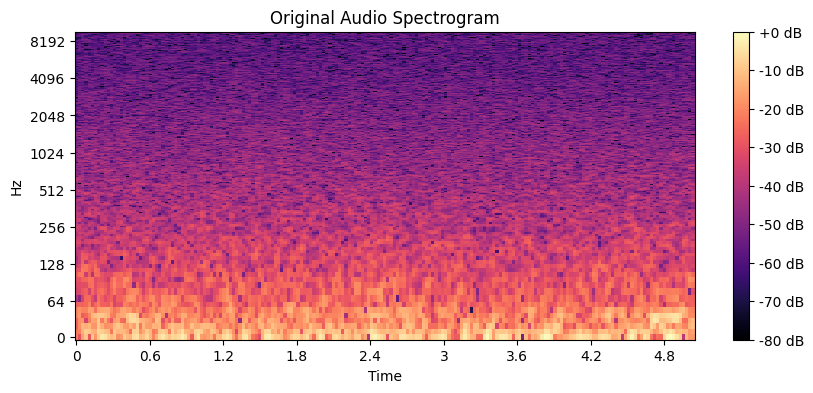

ParameterError: Audio data must be floating-point

<Figure size 1000x400 with 0 Axes>

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    max_val = np.max(original)
    return psnr(original, decompressed, data_range=max_val)

def plot_spectrogram(signal, samplerate, title):
    plt.figure(figsize=(10, 4))
    S = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=samplerate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)
    ssim_value = ssim(original_audio, decompressed_audio)

    plot_spectrogram(original_audio, samplerate, "Original Audio Spectrogram")
    plot_spectrogram(decompressed_audio, samplerate, "Decompressed Audio Spectrogram")

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")


In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.int16 if bit_depth <= 16 else np.int32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    max_val = np.max(original)
    return psnr(original, decompressed, data_range=max_val)

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")


Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def quantize(self, z):
        with torch.no_grad():
            distances = (torch.sum(z ** 2, dim=1, keepdim=True)
                         + torch.sum(self.embedding.weight ** 2, dim=1)
                         - 2 * torch.matmul(z, self.embedding.weight.t()))
            indices = torch.argmin(distances, dim=1)
            z_q = self.embedding(indices)
            return z_q, indices

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        z_q, _ = self.quantize(z)
        return self.decode(z_q), z, z_q

# Define the loss function with additional regularization to enforce losslessness
def vqvae_loss(recon_x, x, z, z_q, beta=0.25, alpha=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x.view_as(recon_x), reduction='sum')
    commitment_loss = nn.functional.mse_loss(z_q, z.detach(), reduction='sum')
    quantization_loss = nn.functional.mse_loss(z, z_q, reduction='sum')
    return recon_loss + beta * commitment_loss + alpha * quantization_loss

# Train the VQ-VAE model with additional loss terms
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            recon_batch, z, z_q = model(data)
            loss = vqvae_loss(recon_batch, data, z, z_q)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataloader.dataset)}')

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            z = model.encode(segment_tensor)
            z_q, indices = model.quantize(z)
            compressed_audio.append(indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int64)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int64)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length, bit_depth=16):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.embedding(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio, axis=0)
    decompressed_audio = (decompressed_audio * (2 ** (bit_depth - 1) - 1)).astype(np.float32)

    if len(decompressed_audio) != original_audio_length:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")


Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

KeyboardInterrupt: 

Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 4 segments of size 32000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 4 segments of size 32000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 4 segments of size 32000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 4 segments of size 32000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 4 segments of size 32000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 4 segments of size 32000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 4 segments of size 32000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 4 segments of size 32000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 4 segments of size 32000
Segmented /content/extract/d

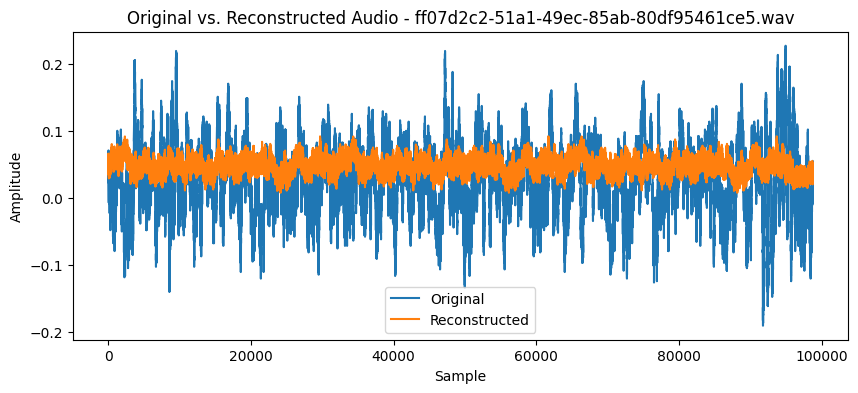

<ipython-input-6-cc620f49b8bd>:325: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  z = vqvae_model.encode(torch.tensor(segments).float())


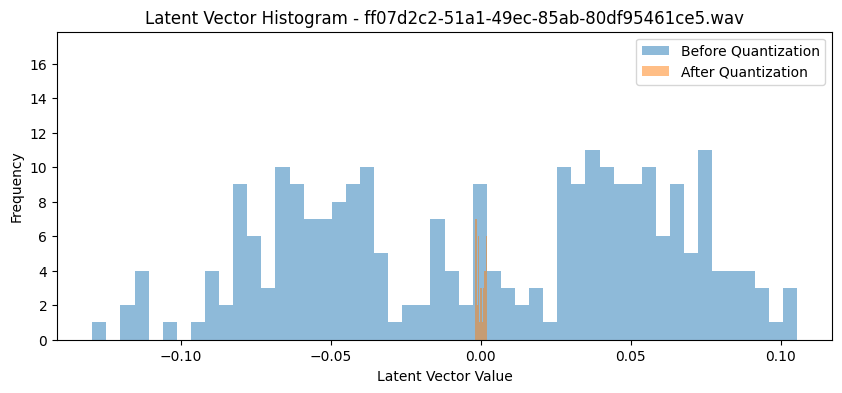

Original Checksum for 81635566-2449-485d-ac29-dc1117eb9af7.wav: 4a467ff5fbb1bc8a9183d8987033f8e1
Segmented /content/extract/data/data/81635566-2449-485d-ac29-dc1117eb9af7.wav into 4 segments of size 32000

Metrics for 81635566-2449-485d-ac29-dc1117eb9af7.wav:
Original Size: 198680 bytes
Compressed Size: 162 bytes
Decompressed Size: 397272 bytes
Compression Ratio: 1226.42
Original Entropy: 16.68 bits
Decompressed Entropy: 16.47 bits
Lossless: No
Decompressed Checksum: 2b1a56224863b6fe0a241aad0ed4e8fc
SNR: 3.69 dB
MSE: 0.001175
PSNR: 29.30 dB


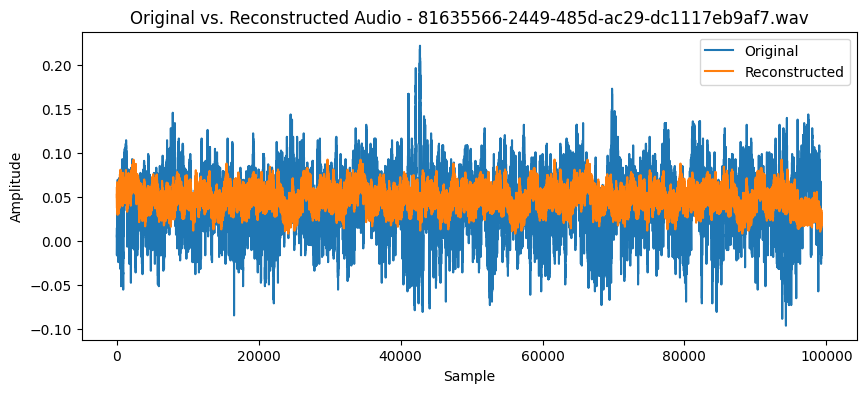

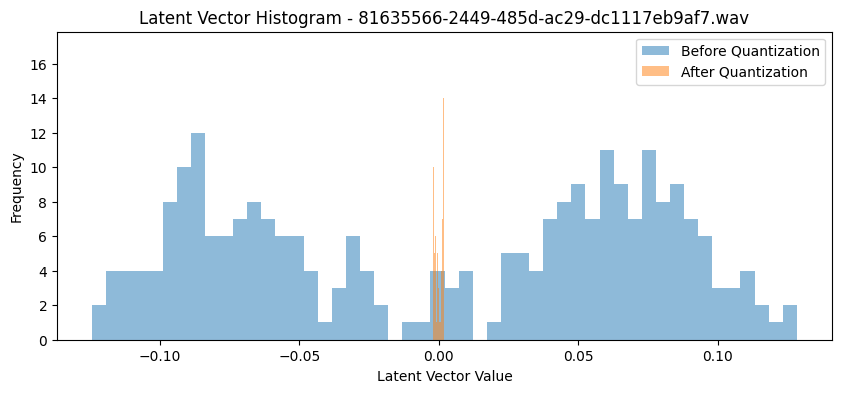

Original Checksum for 5611ca15-4d92-4cef-8187-8b2db56521a2.wav: f1162a1d69c1cd4613b59fcdcf02071c
Segmented /content/extract/data/data/5611ca15-4d92-4cef-8187-8b2db56521a2.wav into 4 segments of size 32000

Metrics for 5611ca15-4d92-4cef-8187-8b2db56521a2.wav:
Original Size: 197558 bytes
Compressed Size: 162 bytes
Decompressed Size: 395028 bytes
Compression Ratio: 1219.49
Original Entropy: 16.67 bits
Decompressed Entropy: 16.46 bits
Lossless: No
Decompressed Checksum: 04e908e5cf5b11890201069250976c4e
SNR: 5.32 dB
MSE: 0.001154
PSNR: 29.38 dB


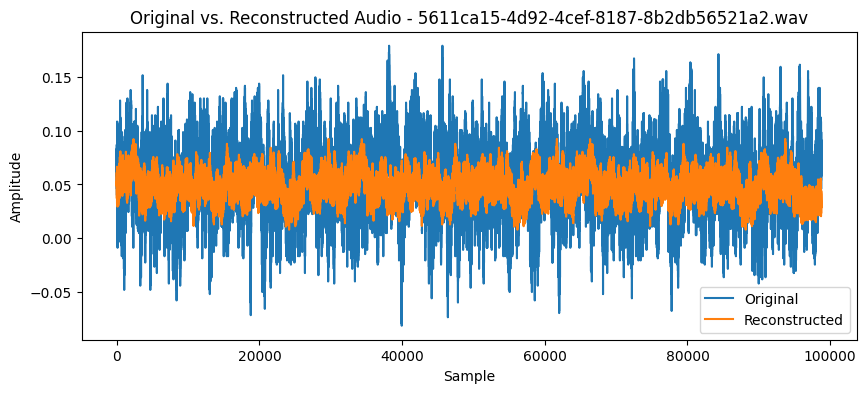

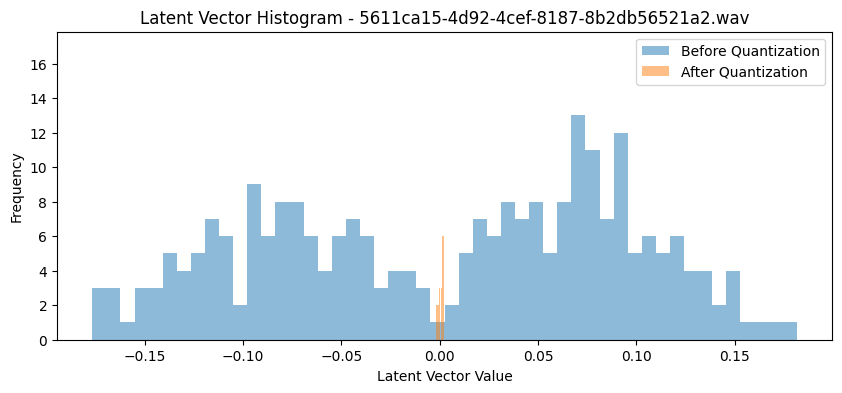

Original Checksum for 43db69f8-b371-4b24-80e4-bff210ece512.wav: c56edb938ce2893f9ca0d3549d0a1be6
Segmented /content/extract/data/data/43db69f8-b371-4b24-80e4-bff210ece512.wav into 4 segments of size 32000

Metrics for 43db69f8-b371-4b24-80e4-bff210ece512.wav:
Original Size: 198020 bytes
Compressed Size: 162 bytes
Decompressed Size: 395952 bytes
Compression Ratio: 1222.35
Original Entropy: 16.68 bits
Decompressed Entropy: 16.47 bits
Lossless: No
Decompressed Checksum: 08c5962e1a751e7b36c78c0ee2c04c73
SNR: 4.66 dB
MSE: 0.001115
PSNR: 29.53 dB


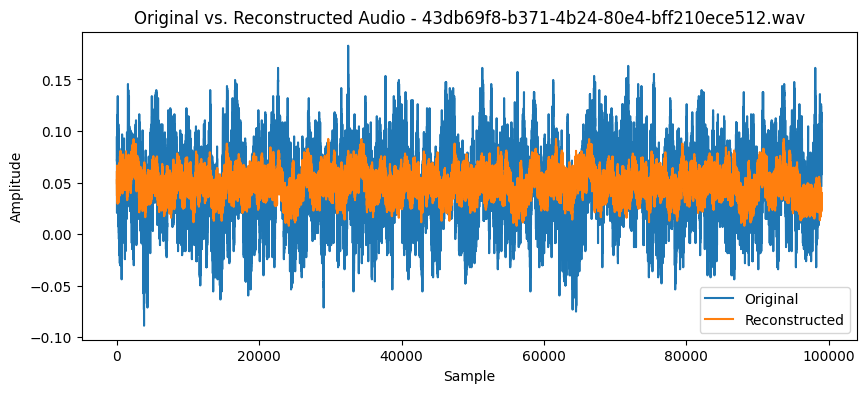

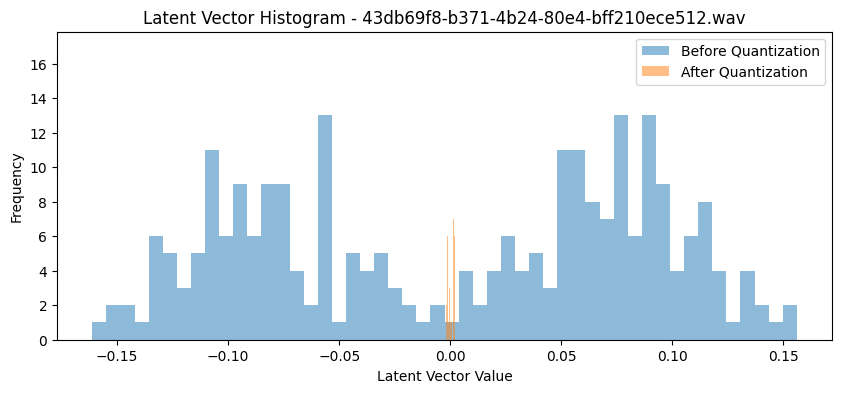

Original Checksum for c1d8e934-fc5c-4d2d-9ba2-47b9fe395fee.wav: 8611d7ce54184e36c5aefb0ff88e81ed
Segmented /content/extract/data/data/c1d8e934-fc5c-4d2d-9ba2-47b9fe395fee.wav into 4 segments of size 32000


In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    if len(decompressed_audio) < original_audio_length:
        decompressed_audio = np.pad(decompressed_audio, (0, original_audio_length - len(decompressed_audio)), 'constant')
    else:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 32000
latent_dim = 64
num_embeddings = 512
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

compression_ratios = []
snr_values = []
psnr_values = []
mse_values = []

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    compression_ratios.append(compression_ratio)
    snr_values.append(snr_value)
    psnr_values.append(psnr_value)
    mse_values.append(mse_value)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")

    # Plot original and reconstructed audio waveforms
    plt.figure(figsize=(10, 4))
    plt.plot(original_audio, label='Original')
    plt.plot(decompressed_audio, label='Reconstructed')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'Original vs. Reconstructed Audio - {file}')
    plt.show()

    # Histogram of latent vector values before and after quantization
    z = vqvae_model.encode(torch.tensor(segments).float())
    z_q = vqvae_model.quantize(torch.argmin(torch.sum((z.unsqueeze(1) - vqvae_model.codebook.weight) ** 2, dim=2), dim=1))
    plt.figure(figsize=(10, 4))
    plt.hist(z.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='Before Quantization')
    plt.hist(z_q.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='After Quantization')
    plt.xlabel('Latent Vector Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Latent Vector Histogram - {file}')
    plt.show()

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from google.colab import files

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    if len(decompressed_audio) < original_audio_length:
        decompressed_audio = np.pad(decompressed_audio, (0, original_audio_length - len(decompressed_audio)), 'constant')
    else:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000  # Reduced segment size
latent_dim = 32  # Reduced latent dimension
num_embeddings = 256  # Reduced number of embeddings
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

compression_ratios = []
snr_values = []
psnr_values = []
mse_values = []

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    compression_ratios.append(compression_ratio)
    snr_values.append(snr_value)
    psnr_values.append(psnr_value)
    mse_values.append(mse_value)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")

    # Plot original and reconstructed audio waveforms
    plt.figure(figsize=(10, 4))
    plt.plot(original_audio, label='Original')
    plt.plot(decompressed_audio, label='Reconstructed')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'Original vs. Reconstructed Audio - {file}')
    plt.savefig(f'/content/{file}_waveform_comparison.png')
    plt.close()

    # Histogram of latent vector values before and after quantization
    z = vqvae_model.encode(torch.tensor(segments).float())
    z_q = vqvae_model.quantize(torch.argmin(torch.sum((z.unsqueeze(1) - vqvae_model.codebook.weight) ** 2, dim=2), dim=1))
    plt.figure(figsize=(10, 4))
    plt.hist(z.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='Before Quantization')
    plt.hist(z_q.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='After Quantization')
    plt.xlabel('Latent Vector Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Latent Vector Histogram - {file}')
    plt.savefig(f'/content/{file}_latent_vector_histogram.png')
    plt.close()

Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

<ipython-input-3-e63a736aa222>:327: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  z = vqvae_model.encode(torch.tensor(segments).float())


Original Checksum for 81635566-2449-485d-ac29-dc1117eb9af7.wav: 4a467ff5fbb1bc8a9183d8987033f8e1
Segmented /content/extract/data/data/81635566-2449-485d-ac29-dc1117eb9af7.wav into 7 segments of size 16000

Metrics for 81635566-2449-485d-ac29-dc1117eb9af7.wav:
Original Size: 198680 bytes
Compressed Size: 273 bytes
Decompressed Size: 397272 bytes
Compression Ratio: 727.77
Original Entropy: 16.68 bits
Decompressed Entropy: 16.49 bits
Lossless: No
Decompressed Checksum: 405dbb38e83a8f221fbd923ed8167124
SNR: 3.82 dB
MSE: 0.001139
PSNR: 29.44 dB
Original Checksum for 5611ca15-4d92-4cef-8187-8b2db56521a2.wav: f1162a1d69c1cd4613b59fcdcf02071c
Segmented /content/extract/data/data/5611ca15-4d92-4cef-8187-8b2db56521a2.wav into 7 segments of size 16000

Metrics for 5611ca15-4d92-4cef-8187-8b2db56521a2.wav:
Original Size: 197558 bytes
Compressed Size: 273 bytes
Decompressed Size: 395028 bytes
Compression Ratio: 723.66
Original Entropy: 16.67 bits
Decompressed Entropy: 16.46 bits
Lossless: No
Decomp

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from google.colab import files

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with improved quantization
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Tanh()  # Added Tanh activation to limit the output range
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    if len(decompressed_audio) < original_audio_length:
        decompressed_audio = np.pad(decompressed_audio, (0, original_audio_length - len(decompressed_audio)), 'constant')
    else:
        decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000  # Reduced segment size
latent_dim = 32  # Reduced latent dimension
num_embeddings = 256  # Reduced number of embeddings
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

compression_ratios = []
snr_values = []
psnr_values = []
mse_values = []

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    compression_ratios.append(compression_ratio)
    snr_values.append(snr_value)
    psnr_values.append(psnr_value)
    mse_values.append(mse_value)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")

    # Plot original and reconstructed audio waveforms
    plt.figure(figsize=(10, 4))
    plt.plot(original_audio, label='Original')
    plt.plot(decompressed_audio, label='Reconstructed')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'Original vs. Reconstructed Audio - {file}')
    plt.savefig(f'/content/{file}_waveform_comparison.png')
    plt.close()

    # Histogram of latent vector values before and after quantization
    # Histogram of latent vector values before and after quantization
    z = vqvae_model.encode(torch.tensor(np.array(segments), dtype=torch.float32))
    z_q = vqvae_model.quantize(torch.argmin(torch.sum((z.unsqueeze(1) - vqvae_model.codebook.weight) ** 2, dim=2), dim=1))
    plt.figure(figsize=(10, 4))
    plt.hist(z.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='Before Quantization')
    plt.hist(z_q.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='After Quantization')
    plt.xlabel('Latent Vector Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Latent Vector Histogram - {file}')
    plt.savefig(f'/content/{file}_latent_vector_histogram.png')
    plt.close()

Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from google.colab import files

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with reduced latent space
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000
latent_dim = 16
num_embeddings = 128
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

compression_ratios = []
snr_values = []
psnr_values = []
mse_values = []

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    compression_ratios.append(compression_ratio)
    snr_values.append(snr_value)
    psnr_values.append(psnr_value)
    mse_values.append(mse_value)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")

    # Plot original and reconstructed audio waveforms
    plt.figure(figsize=(10, 4))
    plt.plot(original_audio, label='Original')
    plt.plot(decompressed_audio, label='Reconstructed')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'Original vs. Reconstructed Audio - {file}')
    plt.savefig(f'/content/{file}_waveform_comparison.png')
    plt.close()



Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from google.colab import files

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with reduced latent space and smaller decoder
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 8000  # Reduced segment size
latent_dim = 8  # Reduced latent dimension
num_embeddings = 64  # Reduced number of embeddings
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

compression_ratios = []
snr_values = []
psnr_values = []
mse_values = []

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    if not segments:
        print(f"Skipping {file} due to errors in segmentation.")
        continue

    compressed_audio = compress_audio(vqvae_model, segments)
    encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

    original_audio, _ = librosa.load(file_path, sr=None, mono=True)
    decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

    snr_value = calculate_snr(original_audio, decompressed_audio)
    mse_value = calculate_mse(original_audio, decompressed_audio)
    psnr_value = calculate_psnr(original_audio, decompressed_audio)

    compression_ratios.append(compression_ratio)
    snr_values.append(snr_value)
    psnr_values.append(psnr_value)
    mse_values.append(mse_value)

    print(f"\nMetrics for {file}:")
    print(f"Original Size: {original_size} bytes")
    print(f"Compressed Size: {compressed_size} bytes")
    print(f"Decompressed Size: {decompressed_size} bytes")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"Original Entropy: {original_entropy:.2f} bits")
    print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
    print(f"Lossless: {'Yes' if is_lossless else 'No'}")
    print(f"Decompressed Checksum: {decompressed_checksum}")
    print(f"SNR: {snr_value:.2f} dB")
    print(f"MSE: {mse_value:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")

    # Plot original and reconstructed audio waveforms
    plt.figure(figsize=(10, 4))
    plt.plot(original_audio, label='Original')
    plt.plot(decompressed_audio, label='Reconstructed')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'Original vs. Reconstructed Audio - {file}')
    plt.savefig(f'/content/{file}_waveform_comparison.png')
    plt.close()

    # Histogram of latent vector values before and after quantization
    z = vqvae_model.encode(torch.tensor(np.array(segments), dtype=torch.float32))
    z_q = vqvae_model.quantize(torch.argmin(torch.sum((z.unsqueeze(1) - vqvae_model.codebook.weight) ** 2, dim=2), dim=1))
    plt.figure(figsize=(10, 4))
    plt.hist(z.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='Before Quantization')
    plt.hist(z_q.detach().cpu().numpy().flatten(), bins=50, alpha=0.5, label='After Quantization')
    plt.xlabel('Latent Vector Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Latent Vector Histogram - {file}')

Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 13 segments of size 8000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 13 segments of size 8000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 13 segments of size 8000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 13 segments of size 8000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 13 segments of size 8000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 13 segments of size 8000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 13 segments of size 8000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 13 segments of size 8000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 13 segments of size 8000
Segmented /content/extract/d

Segmented /content/extract/data/data/98f08414-7707-4248-bef5-d8df6ceaccdb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8e664a04-817f-44ec-9569-bbcb5a173b8c.wav into 7 segments of size 16000
Segmented /content/extract/data/data/174a80d5-dc29-4068-8108-39404d24a6fb.wav into 7 segments of size 16000
Segmented /content/extract/data/data/9d3e4007-4faf-4eb7-9bfd-edb27251734d.wav into 7 segments of size 16000
Segmented /content/extract/data/data/dab03e8b-a025-43bd-af70-51b221ff41c0.wav into 7 segments of size 16000
Segmented /content/extract/data/data/edce7f7e-2e3e-4ce8-9e22-4fd668b0015f.wav into 7 segments of size 16000
Segmented /content/extract/data/data/c9139beb-ef5c-4089-9ddd-6abd7fd0972b.wav into 7 segments of size 16000
Segmented /content/extract/data/data/8b243863-b6f8-43d1-bdc9-05924e82e152.wav into 7 segments of size 16000
Segmented /content/extract/data/data/312b2c93-0838-412d-b408-63c9cf74adf9.wav into 7 segments of size 16000
Segmented /content/extract/d

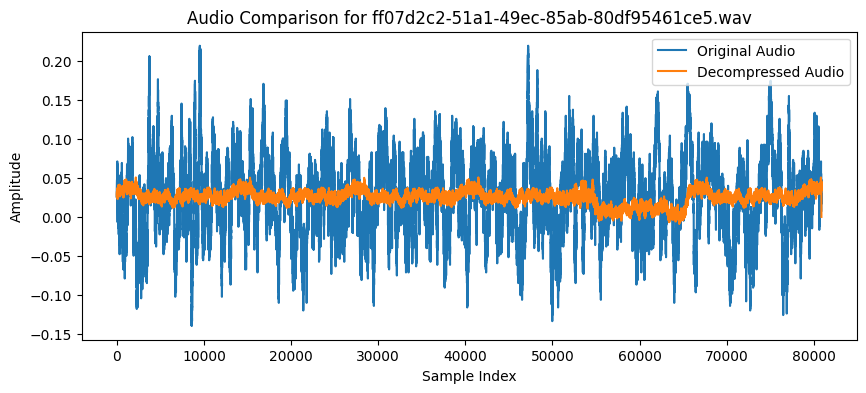

Original Checksum for 81635566-2449-485d-ac29-dc1117eb9af7.wav: 4a467ff5fbb1bc8a9183d8987033f8e1
Segmented /content/extract/data/data/81635566-2449-485d-ac29-dc1117eb9af7.wav into 7 segments of size 16000

Metrics for 81635566-2449-485d-ac29-dc1117eb9af7.wav:
Original Size: 198680 bytes
Compressed Size: 267 bytes
Decompressed Size: 325452 bytes
Compression Ratio: 744.12
Original Entropy: 16.68 bits
Decompressed Entropy: 16.25 bits
Lossless: No
Decompressed Checksum: 950e17b16ee27aafed6988532d1bc21b
SNR: 3.92 dB
MSE: 0.001077
PSNR: 29.68 dB


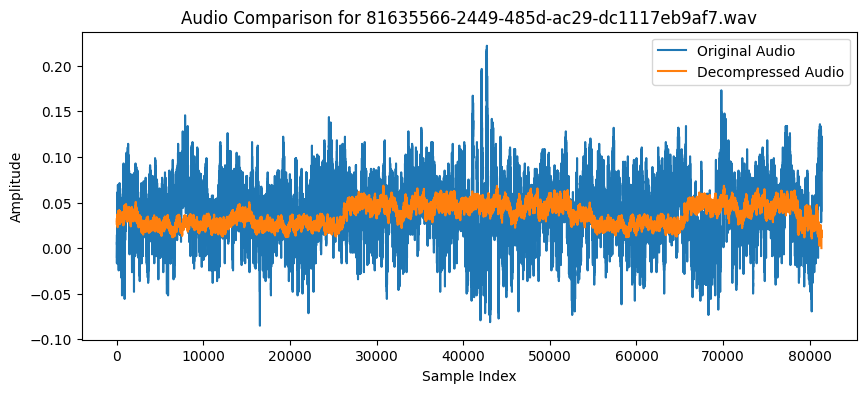

Original Checksum for 5611ca15-4d92-4cef-8187-8b2db56521a2.wav: f1162a1d69c1cd4613b59fcdcf02071c
Segmented /content/extract/data/data/5611ca15-4d92-4cef-8187-8b2db56521a2.wav into 7 segments of size 16000

Metrics for 5611ca15-4d92-4cef-8187-8b2db56521a2.wav:
Original Size: 197558 bytes
Compressed Size: 273 bytes
Decompressed Size: 323612 bytes
Compression Ratio: 723.66
Original Entropy: 16.67 bits
Decompressed Entropy: 16.20 bits
Lossless: No
Decompressed Checksum: 0b17efbdb93f7169bb031ab9124443a8
SNR: 4.88 dB
MSE: 0.001294
PSNR: 28.88 dB


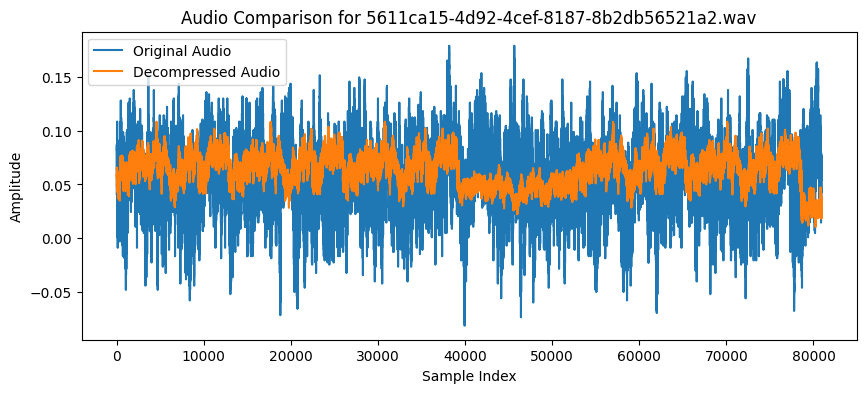

Original Checksum for 43db69f8-b371-4b24-80e4-bff210ece512.wav: c56edb938ce2893f9ca0d3549d0a1be6
Segmented /content/extract/data/data/43db69f8-b371-4b24-80e4-bff210ece512.wav into 7 segments of size 16000

Metrics for 43db69f8-b371-4b24-80e4-bff210ece512.wav:
Original Size: 198020 bytes
Compressed Size: 273 bytes
Decompressed Size: 324372 bytes
Compression Ratio: 725.35
Original Entropy: 16.68 bits
Decompressed Entropy: 16.06 bits
Lossless: No
Decompressed Checksum: 751c84f3d40d04f16bd35a7e628a946d
SNR: 4.62 dB
MSE: 0.001128
PSNR: 29.48 dB


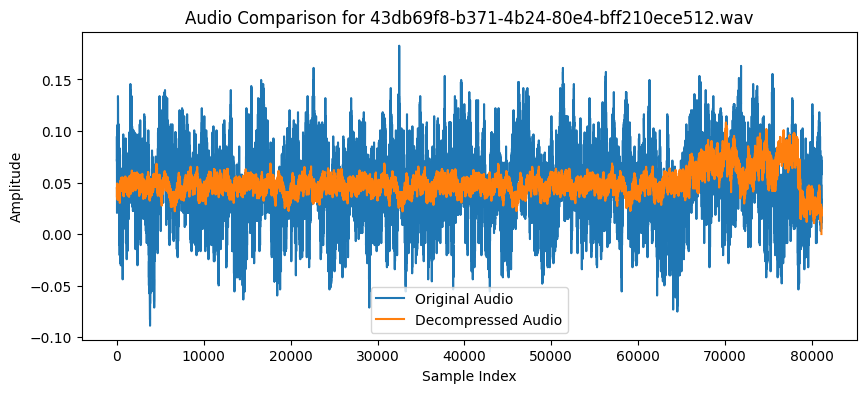

Original Checksum for c1d8e934-fc5c-4d2d-9ba2-47b9fe395fee.wav: 8611d7ce54184e36c5aefb0ff88e81ed
Segmented /content/extract/data/data/c1d8e934-fc5c-4d2d-9ba2-47b9fe395fee.wav into 7 segments of size 16000

Metrics for c1d8e934-fc5c-4d2d-9ba2-47b9fe395fee.wav:
Original Size: 197908 bytes
Compressed Size: 261 bytes
Decompressed Size: 324188 bytes
Compression Ratio: 758.27
Original Entropy: 16.74 bits
Decompressed Entropy: 16.17 bits
Lossless: No
Decompressed Checksum: a8db1c5c900edfe94713d3f543f7e880
SNR: 1.79 dB
MSE: 0.001001
PSNR: 29.99 dB


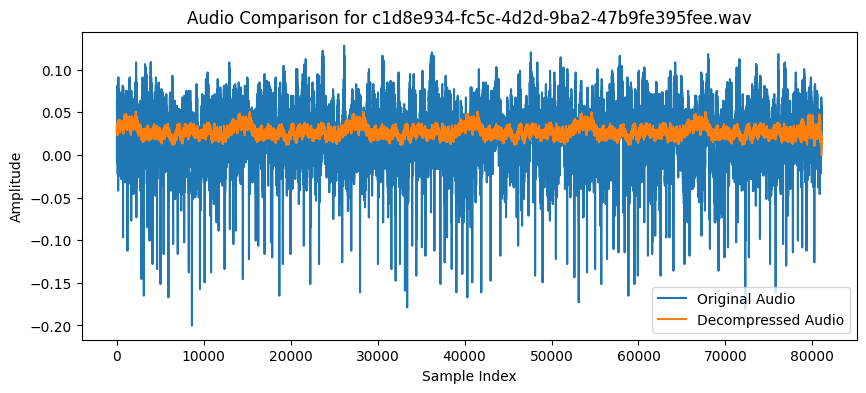

Original Checksum for eae04418-82da-40a0-89ba-ffd44b975295.wav: 2336b0e483ffb6c18591019f180f8daa
Segmented /content/extract/data/data/eae04418-82da-40a0-89ba-ffd44b975295.wav into 7 segments of size 16000

Metrics for eae04418-82da-40a0-89ba-ffd44b975295.wav:
Original Size: 197380 bytes
Compressed Size: 263 bytes
Decompressed Size: 323320 bytes
Compression Ratio: 750.49
Original Entropy: 16.59 bits
Decompressed Entropy: 16.11 bits
Lossless: No
Decompressed Checksum: a39958364523d7346dd9c257f30ae0b5
SNR: 4.21 dB
MSE: 0.000470
PSNR: 33.28 dB


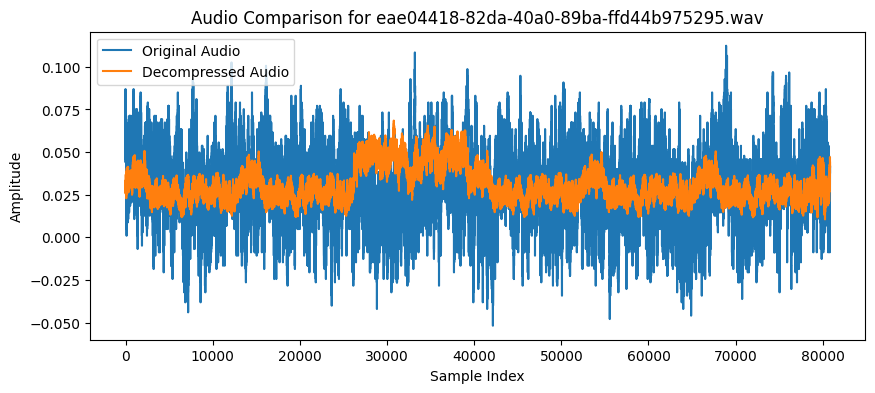

Original Checksum for 85ebe8f7-202a-4357-a296-11204a297936.wav: 99bff433dcf3287890f87cc8a60571c9
Segmented /content/extract/data/data/85ebe8f7-202a-4357-a296-11204a297936.wav into 7 segments of size 16000

Metrics for 85ebe8f7-202a-4357-a296-11204a297936.wav:
Original Size: 197496 bytes
Compressed Size: 271 bytes
Decompressed Size: 323512 bytes
Compression Ratio: 728.77
Original Entropy: 16.62 bits
Decompressed Entropy: 16.07 bits
Lossless: No
Decompressed Checksum: 2fd440dc38138e6d6d2174568c8dad22
SNR: 5.37 dB
MSE: 0.000740
PSNR: 31.31 dB


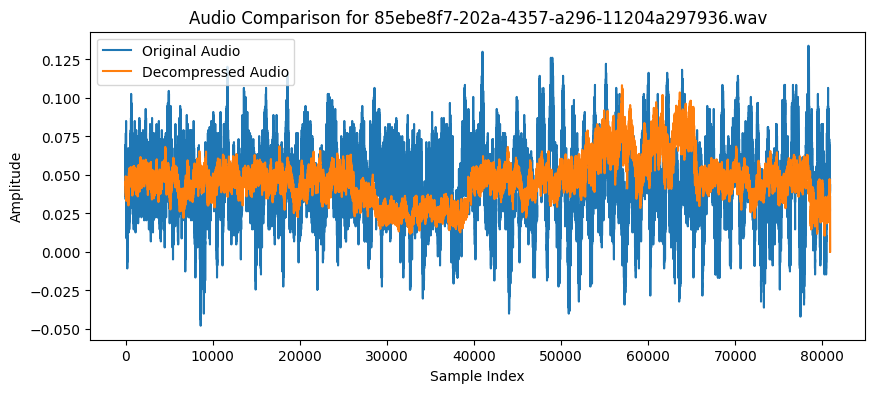

Original Checksum for 9f28ad19-763a-4d25-b9fe-72d86b9d7fb6.wav: a114f48e84bfe7ce458a6b2c4981bf2b
Segmented /content/extract/data/data/9f28ad19-763a-4d25-b9fe-72d86b9d7fb6.wav into 7 segments of size 16000

Metrics for 9f28ad19-763a-4d25-b9fe-72d86b9d7fb6.wav:
Original Size: 197596 bytes
Compressed Size: 263 bytes
Decompressed Size: 323676 bytes
Compression Ratio: 751.32
Original Entropy: 16.94 bits
Decompressed Entropy: 16.14 bits
Lossless: No
Decompressed Checksum: 82d1d77703a22cb43ed768e93d4a285e
SNR: -1.94 dB
MSE: 0.001272
PSNR: 28.96 dB


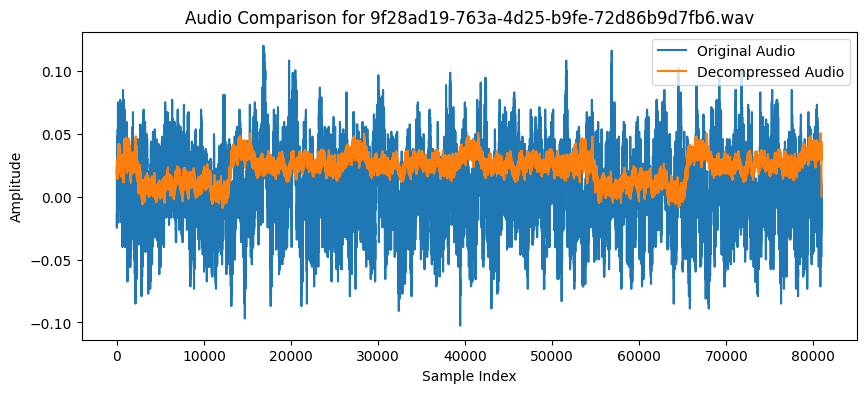

Original Checksum for e350d041-d471-4347-aa47-9c2573daeb0f.wav: 14fc9cbb19e8a414c9f64f004c168182
Segmented /content/extract/data/data/e350d041-d471-4347-aa47-9c2573daeb0f.wav into 7 segments of size 16000

Metrics for e350d041-d471-4347-aa47-9c2573daeb0f.wav:
Original Size: 197550 bytes
Compressed Size: 273 bytes
Decompressed Size: 323600 bytes
Compression Ratio: 723.63
Original Entropy: 16.64 bits
Decompressed Entropy: 16.06 bits
Lossless: No
Decompressed Checksum: 7f4375ab945183fd029afc46ef8a3e95
SNR: 6.26 dB
MSE: 0.000809
PSNR: 30.92 dB


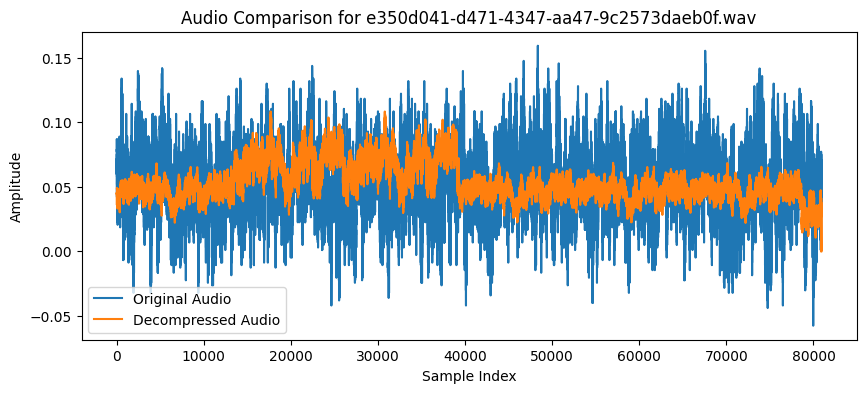

Original Checksum for fdd21dfb-bb59-4f21-a5a2-016b6c80403d.wav: 7b073dc8adc70fdcb9b3b6b5ad55a3ef
Segmented /content/extract/data/data/fdd21dfb-bb59-4f21-a5a2-016b6c80403d.wav into 7 segments of size 16000

Metrics for fdd21dfb-bb59-4f21-a5a2-016b6c80403d.wav:
Original Size: 197506 bytes
Compressed Size: 261 bytes
Decompressed Size: 323528 bytes
Compression Ratio: 756.73
Original Entropy: 16.71 bits
Decompressed Entropy: 16.17 bits
Lossless: No
Decompressed Checksum: 842d0eaeb5fb320bde32810a26a9d689
SNR: 2.46 dB
MSE: 0.000912
PSNR: 30.40 dB


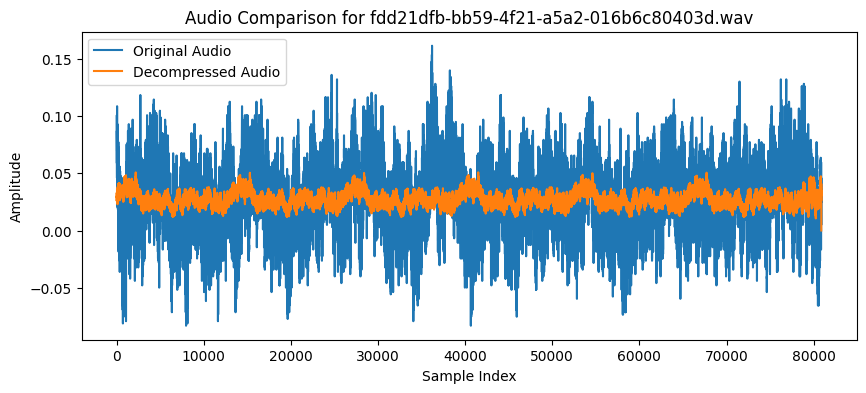

In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with balanced latent space and decoder
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if len(dataloader) > 0:
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        else:
            print("Empty dataloader")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Post-processing: Downsample and trim silence
def post_process_audio(audio, samplerate, target_samplerate=16000, silence_threshold=0.01, silence_duration=0.1):
    # Downsample the audio
    audio = librosa.resample(audio, orig_sr=samplerate, target_sr=target_samplerate)

    # Trim silence
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20, frame_length=int(target_samplerate * silence_duration), hop_length=int(target_samplerate * silence_duration))

    return audio_trimmed

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 16000  # Moderate segment size
latent_dim = 16  # Increased latent dimension for more information capture
num_embeddings = 64  # Reduced number of embeddings for balance
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

if segments_list:
    dataset = AudioDataset(segments_list)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
    train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

    compression_ratios = []
    snr_values = []
    psnr_values = []
    mse_values = []

    for file in last_10_files:
        file_path = os.path.join(data_dir, file)
        original_checksum = file_checksum(file_path)
        print(f"Original Checksum for {file}: {original_checksum}")

        segments, samplerate = segment_audio(file_path, segment_size)
        if not segments:
            print(f"Skipping {file} due to errors in segmentation.")
            continue

        compressed_audio = compress_audio(vqvae_model, segments)
        encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

        original_audio, _ = librosa.load(file_path, sr=None, mono=True)
        decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

        # Apply post-processing
        decompressed_audio = post_process_audio(decompressed_audio, samplerate)

        # Ensure original and decompressed audio have the same length
        min_length = min(len(original_audio), len(decompressed_audio))
        original_audio = original_audio[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
        decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

        snr_value = calculate_snr(original_audio, decompressed_audio)
        mse_value = calculate_mse(original_audio, decompressed_audio)
        psnr_value = calculate_psnr(original_audio, decompressed_audio)

        compression_ratios.append(compression_ratio)
        snr_values.append(snr_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        print(f"\nMetrics for {file}:")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Entropy: {original_entropy:.2f} bits")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
        print(f"Lossless: {'Yes' if is_lossless else 'No'}")
        print(f"Decompressed Checksum: {decompressed_checksum}")
        print(f"SNR: {snr_value:.2f} dB")
        print(f"MSE: {mse_value:.6f}")
        print(f"PSNR: {psnr_value:.2f} dB")

        # Plot original and reconstructed audio
        plt.figure(figsize=(10, 4))
        plt.plot(original_audio, label='Original Audio')
        plt.plot(decompressed_audio, label='Decompressed Audio')
        plt.legend()
        plt.title(f"Audio Comparison for {file}")
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()
else:
    print("No valid segments found for training.")


Segmented /content/extract/data/data/5ba3a321-4aa8-4def-bedc-b800134a8a93.wav into 25 segments of size 4000
Segmented /content/extract/data/data/16ade36e-d993-4d65-8cfd-c5d94ceef5d3.wav into 25 segments of size 4000
Segmented /content/extract/data/data/7d2e10a6-31b6-4d70-bfe3-d2627f1352e4.wav into 25 segments of size 4000
Segmented /content/extract/data/data/6df93e0a-9710-4099-9346-584c1e0ba191.wav into 25 segments of size 4000
Segmented /content/extract/data/data/254000d9-9fd8-43a0-a561-c81a6feee649.wav into 25 segments of size 4000
Segmented /content/extract/data/data/3745a64f-9be1-41fb-975d-9c7c2baa0947.wav into 25 segments of size 4000
Segmented /content/extract/data/data/9dd6dd15-40a5-46c4-9b0c-df4ec68abeb8.wav into 25 segments of size 4000
Segmented /content/extract/data/data/3952aa1a-7eac-483b-8203-5f857bf9af10.wav into 25 segments of size 4000
Segmented /content/extract/data/data/cd49e9f1-12fe-4cbd-b955-8a2145d1dec6.wav into 25 segments of size 4000
Segmented /content/extract/d

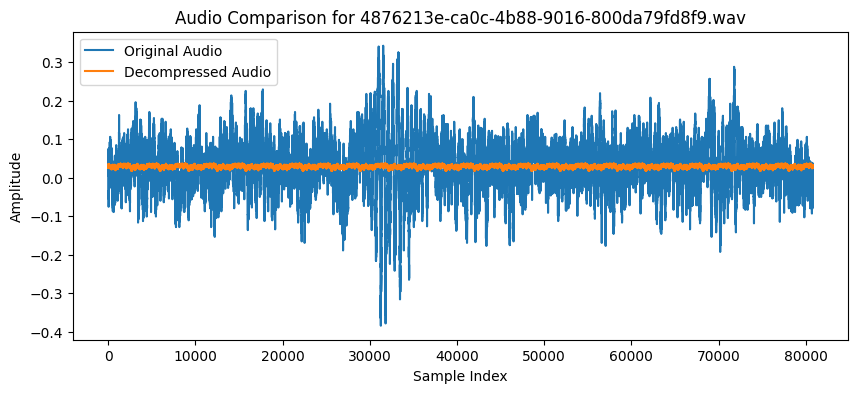

Original Checksum for 6a8f6a6e-48ce-4e1f-a22e-8237c4123323.wav: 9869bbe80a7d8039bb550b165e468b3b
Segmented /content/extract/data/data/6a8f6a6e-48ce-4e1f-a22e-8237c4123323.wav into 25 segments of size 4000

Metrics for 6a8f6a6e-48ce-4e1f-a22e-8237c4123323.wav:
Original Size: 197332 bytes
Compressed Size: 925 bytes
Decompressed Size: 323244 bytes
Compression Ratio: 213.33
Original Entropy: 16.57 bits
Decompressed Entropy: 16.20 bits
Lossless: No
Decompressed Checksum: 5fa4f6fd1742f3fac6478f1cff396bb1
SNR: 6.62 dB
MSE: 0.000343
PSNR: 34.65 dB


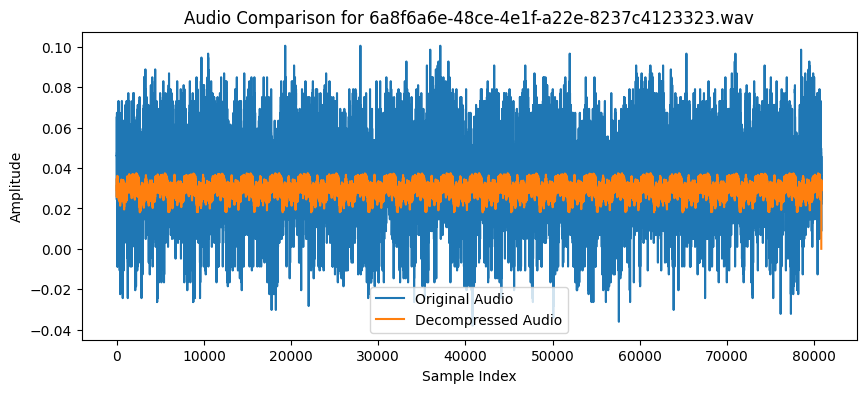

Original Checksum for a733c939-5c3b-479e-8341-0862c3984aa3.wav: 0255fedb8560dc8affea76852d76088b
Segmented /content/extract/data/data/a733c939-5c3b-479e-8341-0862c3984aa3.wav into 25 segments of size 4000

Metrics for a733c939-5c3b-479e-8341-0862c3984aa3.wav:
Original Size: 197518 bytes
Compressed Size: 925 bytes
Decompressed Size: 323548 bytes
Compression Ratio: 213.53
Original Entropy: 16.78 bits
Decompressed Entropy: 16.20 bits
Lossless: No
Decompressed Checksum: 7556db1b14cf83b048dc570642fef722
SNR: 2.35 dB
MSE: 0.003744
PSNR: 24.27 dB


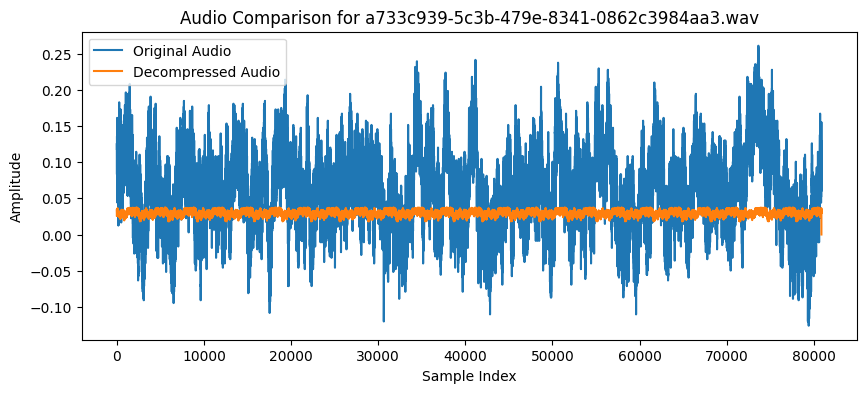

Original Checksum for 0161dc01-ec36-4fe7-bbbc-1801586d28f7.wav: 7a4378a73e1451ba0b984bedf6b7ae5c
Segmented /content/extract/data/data/0161dc01-ec36-4fe7-bbbc-1801586d28f7.wav into 25 segments of size 4000


In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a VQ-VAE architecture with balanced latent space and decoder
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),  # Reduced to balance capacity
            nn.ReLU(),
            nn.Linear(256, 128),  # Reduced to balance capacity
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),  # Reduced to balance capacity
            nn.ReLU(),
            nn.Linear(128, 256),  # Reduced to balance capacity
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define the loss function
def vqvae_loss(x, x_recon, z, z_q, commitment_loss, alpha=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x)
    vq_loss = torch.mean((z_q.detach() - z) ** 2)
    loss = recon_loss + alpha * vq_loss + commitment_loss
    return loss

# Train the VQ-VAE model
def train_vqvae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon, z, encoding_indices, commitment_loss = model(data)
            loss = vqvae_loss(data, x_recon, z, model.quantize(encoding_indices), commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if len(dataloader) > 0:
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        else:
            print("Empty dataloader")

# Compress the audio segments using the trained VQ-VAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained VQ-VAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.quantize(indices_tensor)
            recon_segment = model.decode(z_q)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Post-processing: Downsample and trim silence
def post_process_audio(audio, samplerate, target_samplerate=16000, silence_threshold=0.01, silence_duration=0.1):
    # Downsample the audio
    audio = librosa.resample(audio, orig_sr=samplerate, target_sr=target_samplerate)

    # Trim silence
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20, frame_length=int(target_samplerate * silence_duration), hop_length=int(target_samplerate * silence_duration))

    return audio_trimmed

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - encoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 4000  # Moderate segment size to balance detail and decompressed size
latent_dim = 8  # Reduced latent dimension for more compact representation
num_embeddings = 16  # Reduced number of embeddings for balance
embedding_dim = latent_dim

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

if segments_list:
    dataset = AudioDataset(segments_list)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    vqvae_model = VQVAE(segment_size, latent_dim, num_embeddings, embedding_dim)
    train_vqvae(vqvae_model, dataloader, epochs=100, lr=1e-3)

    compression_ratios = []
    snr_values = []
    psnr_values = []
    mse_values = []

    for file in last_10_files:
        file_path = os.path.join(data_dir, file)
        original_checksum = file_checksum(file_path)
        print(f"Original Checksum for {file}: {original_checksum}")

        segments, samplerate = segment_audio(file_path, segment_size)
        if not segments:
            print(f"Skipping {file} due to errors in segmentation.")
            continue

        compressed_audio = compress_audio(vqvae_model, segments)
        encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

        original_audio, _ = librosa.load(file_path, sr=None, mono=True)
        decompressed_audio = decompress_audio(vqvae_model, encoded_audio, len(original_audio))

        # Apply post-processing
        decompressed_audio = post_process_audio(decompressed_audio, samplerate)

        # Ensure original and decompressed audio have the same length
        min_length = min(len(original_audio), len(decompressed_audio))
        original_audio = original_audio[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
        decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

        snr_value = calculate_snr(original_audio, decompressed_audio)
        mse_value = calculate_mse(original_audio, decompressed_audio)
        psnr_value = calculate_psnr(original_audio, decompressed_audio)

        compression_ratios.append(compression_ratio)
        snr_values.append(snr_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        print(f"\nMetrics for {file}:")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Entropy: {original_entropy:.2f} bits")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
        print(f"Lossless: {'Yes' if is_lossless else 'No'}")
        print(f"Decompressed Checksum: {decompressed_checksum}")
        print(f"SNR: {snr_value:.2f} dB")
        print(f"MSE: {mse_value:.6f}")
        print(f"PSNR: {psnr_value:.2f} dB")

        # Plot original and reconstructed audio
        plt.figure(figsize=(10, 4))
        plt.plot(original_audio, label='Original Audio')
        plt.plot(decompressed_audio, label='Decompressed Audio')
        plt.legend()
        plt.title(f"Audio Comparison for {file}")
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()
else:
    print("No valid segments found for training.")


Segmented /content/extract/data/data/5ba3a321-4aa8-4def-bedc-b800134a8a93.wav into 13 segments of size 8000
Segmented /content/extract/data/data/16ade36e-d993-4d65-8cfd-c5d94ceef5d3.wav into 13 segments of size 8000
Segmented /content/extract/data/data/7d2e10a6-31b6-4d70-bfe3-d2627f1352e4.wav into 13 segments of size 8000
Segmented /content/extract/data/data/6df93e0a-9710-4099-9346-584c1e0ba191.wav into 13 segments of size 8000
Segmented /content/extract/data/data/254000d9-9fd8-43a0-a561-c81a6feee649.wav into 13 segments of size 8000
Segmented /content/extract/data/data/3745a64f-9be1-41fb-975d-9c7c2baa0947.wav into 13 segments of size 8000
Segmented /content/extract/data/data/9dd6dd15-40a5-46c4-9b0c-df4ec68abeb8.wav into 13 segments of size 8000
Segmented /content/extract/data/data/3952aa1a-7eac-483b-8203-5f857bf9af10.wav into 13 segments of size 8000
Segmented /content/extract/data/data/cd49e9f1-12fe-4cbd-b955-8a2145d1dec6.wav into 13 segments of size 8000
Segmented /content/extract/d

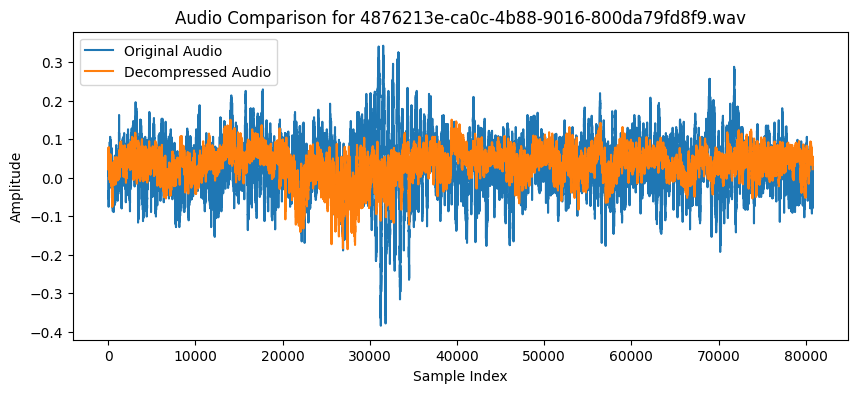

Original Checksum for 6a8f6a6e-48ce-4e1f-a22e-8237c4123323.wav: 9869bbe80a7d8039bb550b165e468b3b
Segmented /content/extract/data/data/6a8f6a6e-48ce-4e1f-a22e-8237c4123323.wav into 13 segments of size 8000

Metrics for 6a8f6a6e-48ce-4e1f-a22e-8237c4123323.wav:
Original Size: 197332 bytes
Compressed Size: 5081 bytes
Decompressed Size: 323244 bytes
Compression Ratio: 38.84
Original Entropy: 16.57 bits
Decompressed Entropy: 16.15 bits
Lossless: No
Decompressed Checksum: 67ce9f7b1f74b0af8bf696d6a48c126c
SNR: 3.81 dB
MSE: 0.000654
PSNR: 31.84 dB


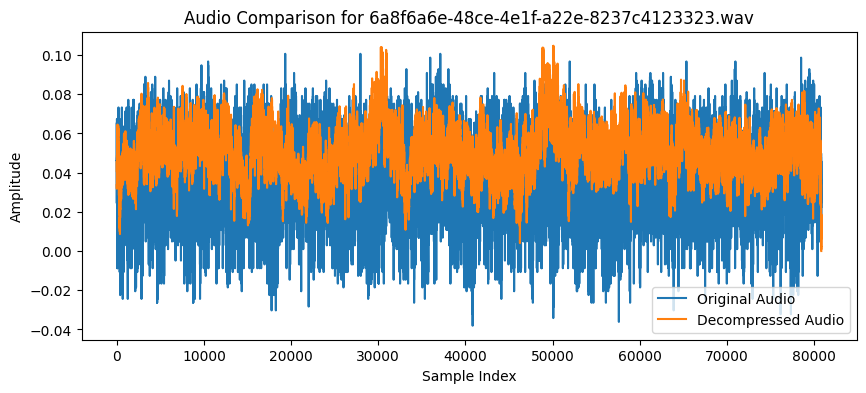

Original Checksum for a733c939-5c3b-479e-8341-0862c3984aa3.wav: 0255fedb8560dc8affea76852d76088b
Segmented /content/extract/data/data/a733c939-5c3b-479e-8341-0862c3984aa3.wav into 13 segments of size 8000

Metrics for a733c939-5c3b-479e-8341-0862c3984aa3.wav:
Original Size: 197518 bytes
Compressed Size: 5064 bytes
Decompressed Size: 323548 bytes
Compression Ratio: 39.00
Original Entropy: 16.78 bits
Decompressed Entropy: 16.11 bits
Lossless: No
Decompressed Checksum: 362eaed2de3e95637e358890963de40c
SNR: 1.45 dB
MSE: 0.004604
PSNR: 23.37 dB


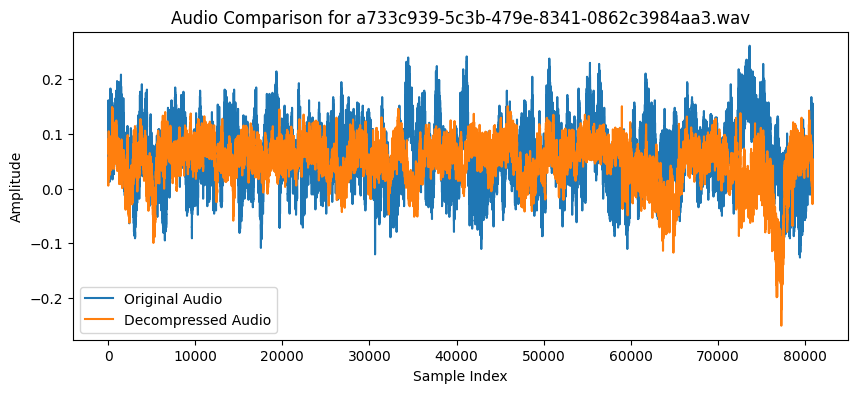

Original Checksum for 0161dc01-ec36-4fe7-bbbc-1801586d28f7.wav: 7a4378a73e1451ba0b984bedf6b7ae5c
Segmented /content/extract/data/data/0161dc01-ec36-4fe7-bbbc-1801586d28f7.wav into 13 segments of size 8000


In [ ]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
from scipy.stats import entropy, gaussian_kde
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define a Convolutional Autoencoder (CAE) with dilated convolutions
class CAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * (input_dim // 16), latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * (input_dim // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (128, input_dim // 16)),
            nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

# Define the loss function
def cae_loss(x, x_recon):
    return nn.functional.mse_loss(x_recon, x)

# Train the CAE model
def train_cae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float().unsqueeze(1)  # Add channel dimension
            optimizer.zero_grad()
            x_recon, z = model(data)
            loss = cae_loss(data, x_recon)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Compress the audio segments using the trained CAE model
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0).unsqueeze(1)  # Add batch and channel dimensions
            _, z = model(segment_tensor)
            compressed_audio.append(z.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.float32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.float32)
    return indices

# Decompress the audio using the trained CAE model
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)  # Add batch dimension
            recon_segment = model.decode(indices_tensor)
            decompressed_audio.append(recon_segment.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Post-processing: Downsample and trim silence
def post_process_audio(audio, samplerate, target_samplerate=16000, silence_threshold=0.01, silence_duration=0.1):
    # Downsample the audio
    audio = librosa.resample(audio, orig_sr=samplerate, target_sr=target_samplerate)

    # Trim silence
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20, frame_length=int(target_samplerate * silence_duration), hop_length=int(target_samplerate * silence_duration))

    return audio_trimmed

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 8000  # Adjusted segment size
latent_dim = 64  # Adjusted latent dimension for more compact representation

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

if segments_list:
    dataset = AudioDataset(segments_list)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    cae_model = CAE(segment_size, latent_dim)
    train_cae(cae_model, dataloader, epochs=100, lr=1e-3)

    compression_ratios = []
    snr_values = []
    psnr_values = []
    mse_values = []

    for file in last_10_files:
        file_path = os.path.join(data_dir, file)
        original_checksum = file_checksum(file_path)
        print(f"Original Checksum for {file}: {original_checksum}")

        segments, samplerate = segment_audio(file_path, segment_size)
        if not segments:
            print(f"Skipping {file} due to errors in segmentation.")
            continue

        compressed_audio = compress_audio(cae_model, segments)
        encoded_audio = [entropy_encode(indices) for indices in compressed_audio]

        original_audio, _ = librosa.load(file_path, sr=None, mono=True)
        decompressed_audio = decompress_audio(cae_model, encoded_audio, len(original_audio))

        # Apply post-processing
        decompressed_audio = post_process_audio(decompressed_audio, samplerate)

        # Ensure original and decompressed audio have the same length
        min_length = min(len(original_audio), len(decompressed_audio))
        original_audio = original_audio[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

        compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, encoded_audio, decompressed_audio)

        is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
        decompressed_checksum = hashlib.md5(decompressed_audio.tobytes()).hexdigest()

        snr_value = calculate_snr(original_audio, decompressed_audio)
        mse_value = calculate_mse(original_audio, decompressed_audio)
        psnr_value = calculate_psnr(original_audio, decompressed_audio)

        compression_ratios.append(compression_ratio)
        snr_values.append(snr_value)
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)

        print(f"\nMetrics for {file}:")
        print(f"Original Size: {original_size} bytes")
        print(f"Compressed Size: {compressed_size} bytes")
        print(f"Decompressed Size: {decompressed_size} bytes")
        print(f"Compression Ratio: {compression_ratio:.2f}")
        print(f"Original Entropy: {original_entropy:.2f} bits")
        print(f"Decompressed Entropy: {decompressed_entropy:.2f} bits")
        print(f"Lossless: {'Yes' if is_lossless else 'No'}")
        print(f"Decompressed Checksum: {decompressed_checksum}")
        print(f"SNR: {snr_value:.2f} dB")
        print(f"MSE: {mse_value:.6f}")
        print(f"PSNR: {psnr_value:.2f} dB")

        # Plot original and reconstructed audio
        plt.figure(figsize=(10, 4))
        plt.plot(original_audio, label='Original Audio')
        plt.plot(decompressed_audio, label='Decompressed Audio')
        plt.legend()
        plt.title(f"Audio Comparison for {file}")
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()
else:
    print("No valid segments found for training.")


Segmented /content/extract/data/data/1c6bf8b8-7bef-439d-ab17-cd338288e977.wav into 13 segments of size 8000
Segmented /content/extract/data/data/9496c16e-a591-4a78-870f-744822a847e6.wav into 13 segments of size 8000
Segmented /content/extract/data/data/3960fcd4-393c-47c3-8935-892c1b0da34d.wav into 13 segments of size 8000
Segmented /content/extract/data/data/70273408-6898-4ce0-891a-d6fa78db2d1d.wav into 13 segments of size 8000
Segmented /content/extract/data/data/c34dae3b-a6cf-4fb0-8d1f-460d42b2ba7a.wav into 13 segments of size 8000
Segmented /content/extract/data/data/da6c3a3b-db48-4c13-884c-3f33f5d2b964.wav into 13 segments of size 8000
Segmented /content/extract/data/data/30dee5fe-ded7-4978-9480-e40155e7b060.wav into 13 segments of size 8000
Segmented /content/extract/data/data/90b1352d-e3e0-460d-885b-73ddf5fb27e1.wav into 13 segments of size 8000
Segmented /content/extract/data/data/08d069d4-366c-41aa-946b-eaa3eb8f9565.wav into 13 segments of size 8000
Segmented /content/extract/d

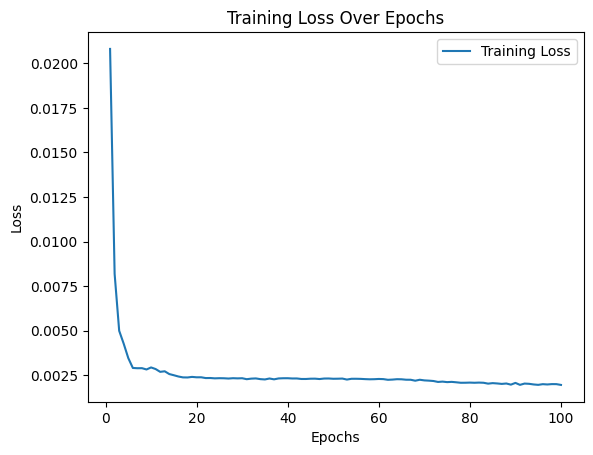

Original Checksum for db1a562f-d9ca-433a-9375-4203ee149d3e.wav: 969db35378e1e0e4132d13d9221c938f
Segmented /content/extract/data/data/db1a562f-d9ca-433a-9375-4203ee149d3e.wav into 13 segments of size 8000
Input to CAE in decompression: torch.Size([1, 1, 1, 1, 8000])
Input to CAE encoder: torch.Size([1, 1, 8000])
Output from CAE encoder: torch.Size([1, 16, 1000])
Output from CAE decoder: torch.Size([1, 1, 8000])
Input to CAE in decompression: torch.Size([1, 1, 1, 1, 8000])
Input to CAE encoder: torch.Size([1, 1, 8000])
Output from CAE encoder: torch.Size([1, 16, 1000])
Output from CAE decoder: torch.Size([1, 1, 8000])
Input to CAE in decompression: torch.Size([1, 1, 1, 1, 8000])
Input to CAE encoder: torch.Size([1, 1, 8000])
Output from CAE encoder: torch.Size([1, 16, 1000])
Output from CAE decoder: torch.Size([1, 1, 8000])
Input to CAE in decompression: torch.Size([1, 1, 1, 1, 8000])
Input to CAE encoder: torch.Size([1, 1, 8000])
Output from CAE encoder: torch.Size([1, 16, 1000])
Outpu

In [31]:
import os
import hashlib
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import bz2
import time
import soundfile as sf
from scipy.stats import entropy, gaussian_kde
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Segment the audio file into smaller segments
def segment_audio(file_path, segment_size):
    try:
        audio_data, samplerate = librosa.load(file_path, sr=None, mono=True)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return [], 0

    if audio_data.ndim != 1:
        print(f"Error: {file_path} has more than one channel.")
        return [], samplerate

    segments = [audio_data[i:i + segment_size] for i in range(0, len(audio_data), segment_size)]
    for i in range(len(segments)):
        if len(segments[i]) < segment_size:
            segments[i] = np.pad(segments[i], (0, segment_size - len(segments[i])), 'constant')
    print(f"Segmented {file_path} into {len(segments)} segments of size {segment_size}")
    return segments, samplerate

# Dataset class for loading audio segments
class AudioDataset(Dataset):
    def __init__(self, segments):
        self.segments = segments

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx]

# Define the HybridModel architecture
class HybridModel(nn.Module):
    def __init__(self, input_dim, latent_dim_vqvae, latent_dim_cae, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(HybridModel, self).__init__()
        self.vqvae = VQVAE(input_dim, latent_dim_vqvae, num_embeddings, embedding_dim, commitment_cost)
        self.cae = CAE(latent_dim_vqvae, latent_dim_cae)

    def forward(self, x):
        x_recon_vqvae, z_vqvae, encoding_indices, commitment_loss = self.vqvae(x)
        z_cae = self.cae.encoder(x_recon_vqvae.unsqueeze(1))  # Ensure correct shape
        x_recon_cae = self.cae.decoder(z_cae)
        return x_recon_cae.squeeze(1), x_recon_vqvae, z_vqvae, encoding_indices, commitment_loss

# Define a VQ-VAE architecture
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()
        )
        self.commitment_cost = commitment_cost

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def quantize(self, encoding_indices):
        return self.codebook(encoding_indices)

    def forward(self, x):
        z = self.encode(x)
        encoding_indices = torch.argmin(torch.sum((z.unsqueeze(1) - self.codebook.weight) ** 2, dim=2), dim=1)
        z_q = self.quantize(encoding_indices)
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z) ** 2)
        z_q = z + (z_q - z).detach()
        x_recon = self.decode(z_q)
        return x_recon, z, encoding_indices, commitment_loss

# Define a Convolutional Autoencoder (CAE) architecture
class CAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, latent_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        print(f"Input to CAE encoder: {x.shape}")
        z = self.encoder(x)
        print(f"Output from CAE encoder: {z.shape}")
        x_recon = self.decoder(z)
        print(f"Output from CAE decoder: {x_recon.shape}")
        return x_recon

def hybrid_loss(model, x, x_recon_cae, x_recon_vqvae, z_vqvae, encoding_indices, commitment_loss, alpha=1.0):
    recon_loss_vqvae = nn.functional.mse_loss(x_recon_vqvae, x)
    recon_loss_cae = nn.functional.mse_loss(x_recon_cae, x)

    # Directly retrieve the quantized vectors using encoding_indices
    z_q = model.vqvae.quantize(encoding_indices)

    print(f"Shape of z_vqvae: {z_vqvae.shape}")
    print(f"Shape of encoding_indices: {encoding_indices.shape}")
    print(f"Shape of z_q: {z_q.shape}")

    vq_loss = torch.mean((z_vqvae.detach() - z_q.float()) ** 2)
    commitment_loss = torch.mean(commitment_loss)  # Ensure commitment_loss is a scalar
    total_loss = recon_loss_cae + alpha * (recon_loss_vqvae + vq_loss + commitment_loss)

    print(f"Recon Loss VQVAE: {recon_loss_vqvae.item()}")
    print(f"Recon Loss CAE: {recon_loss_cae.item()}")
    print(f"VQ Loss: {vq_loss.item()}")
    print(f"Commitment Loss: {commitment_loss.item()}")
    print(f"Total Loss: {total_loss.item()}")

    return total_loss

# Train the HybridModel
def train_hybrid_model(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.float()
            optimizer.zero_grad()
            x_recon_cae, x_recon_vqvae, z_vqvae, encoding_indices, commitment_loss = model(data)
            loss = hybrid_loss(model, data, x_recon_cae, x_recon_vqvae, z_vqvae, encoding_indices, commitment_loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return epoch_losses

# Compress the audio segments using the trained HybridModel
def compress_audio(model, segments):
    compressed_audio = []
    model.eval()
    with torch.no_grad():
        for segment in segments:
            segment_tensor = torch.tensor(segment).float().unsqueeze(0)
            _, _, _, encoding_indices, _ = model(segment_tensor)
            compressed_audio.append(encoding_indices.cpu().numpy())
    compressed_audio = np.array(compressed_audio, dtype=np.int32)
    return compressed_audio

# Apply entropy coding to the quantized vectors
def entropy_encode(indices):
    indices_bytes = indices.tobytes()
    compressed_indices = bz2.compress(indices_bytes)
    return compressed_indices

# Decode the entropy encoded vectors
def entropy_decode(encoded_indices):
    decompressed_indices = bz2.decompress(encoded_indices)
    indices = np.frombuffer(decompressed_indices, dtype=np.int32)
    return indices

# Decompress the audio using the trained HybridModel
def decompress_audio(model, compressed_audio, original_audio_length):
    decompressed_audio = []
    model.eval()
    with torch.no_grad():
        for encoded_indices in compressed_audio:
            indices = entropy_decode(encoded_indices)
            indices_tensor = torch.tensor(indices).unsqueeze(0)
            z_q = model.vqvae.quantize(indices_tensor)
            recon_segment_vqvae = model.vqvae.decode(z_q)
            recon_segment_vqvae = recon_segment_vqvae.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            print(f"Input to CAE in decompression: {recon_segment_vqvae.shape}")
            recon_segment_vqvae = recon_segment_vqvae.view(1, 1, -1)  # Reshape to [batch_size, num_channels, segment_size]
            recon_segment_cae = model.cae(recon_segment_vqvae)  # Pass the input with the correct shape to CAE
            decompressed_audio.append(recon_segment_cae.squeeze().numpy())

    decompressed_audio = np.concatenate(decompressed_audio)
    decompressed_audio = decompressed_audio[:original_audio_length]

    return decompressed_audio

# Post-processing: Downsample and trim silence
def post_process_audio(audio, samplerate, target_samplerate=16000, silence_threshold=0.01, silence_duration=0.1):
    audio = librosa.resample(audio, orig_sr=samplerate, target_sr=target_samplerate)
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20, frame_length=int(target_samplerate * silence_duration), hop_length=int(target_samplerate * silence_duration))
    return audio_trimmed

# Measure encoding and decoding time
def measure_encoding_decoding_time(model, segments, compressed_audio, segment_size):
    encoding_start_time = time.time()
    compress_audio(model, segments)
    encoding_end_time = time.time()
    encoding_time = encoding_end_time - encoding_start_time

    decoding_start_time = time.time()
    decompress_audio(model, compressed_audio, segment_size * len(segments))
    decoding_end_time = time.time()
    decoding_time = decoding_end_time - decoding_start_time

    return encoding_time, decoding_time

# Calculate compression ratio, decompressed size, and entropy
def calculate_metrics(original_file, compressed_audio, decompressed_audio):
    original_size = os.path.getsize(original_file)
    compressed_size = sum(len(c) for c in compressed_audio)
    decompressed_size = decompressed_audio.nbytes
    compression_ratio = original_size / compressed_size

    original_entropy = entropy(np.frombuffer(open(original_file, 'rb').read(), dtype=np.uint8), base=2)

    decompressed_data = decompressed_audio.astype(np.float64)
    decompressed_data += 1e-8
    decompressed_kde = gaussian_kde(decompressed_data)
    decompressed_entropy = entropy(decompressed_kde.evaluate(decompressed_data), base=2)

    return compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy

# Compare the original and decompressed audio data
def compare_audio(original_file, decompressed_audio, samplerate):
    try:
        original_data, _ = librosa.load(original_file, sr=samplerate, mono=True)
    except Exception as e:
        print(f"Error reading file {original_file}: {e}")
        return False

    original_length = len(original_data)
    decompressed_length = len(decompressed_audio)
    if original_length != decompressed_length:
        min_length = min(original_length, decompressed_length)
        original_data = original_data[:min_length]
        decompressed_audio = decompressed_audio[:min_length]

    original_data = original_data / np.max(np.abs(original_data))
    decompressed_audio = decompressed_audio / np.max(np.abs(decompressed_audio))

    diff = np.abs(original_data - decompressed_audio)
    max_diff = np.max(diff)
    lossless_threshold = 1e-6
    if max_diff <= lossless_threshold:
        return True
    else:
        return False

# Calculate file checksum
def file_checksum(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

# Calculate additional metrics
def calculate_snr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - decompressed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

def calculate_mse(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    return np.mean((original - decompressed) ** 2)

def calculate_psnr(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    mse_value = calculate_mse(original, decompressed)
    if mse_value == 0:
        return float('inf')
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

def calculate_ssim(original, decompressed):
    min_length = min(len(original), len(decompressed))
    original = original[:min_length]
    decompressed = decompressed[:min_length]

    return ssim(original, decompressed)

# Example usage
data_dir = '/content/extract/data/data'
segment_size = 8000
latent_dim_vqvae = 8
latent_dim_cae = 16
num_embeddings = 128
embedding_dim = latent_dim_vqvae

wav_files = [file for file in os.listdir(data_dir) if file.endswith('.wav')]
first_10_files = wav_files[:10]
last_10_files = wav_files[-10:]

segments_list = []
samplerate_list = []
for file in first_10_files:
    file_path = os.path.join(data_dir, file)
    segments, samplerate = segment_audio(file_path, segment_size)
    if segments:
        segments_list.extend(segments)
        samplerate_list.append(samplerate)

dataset = AudioDataset(segments_list)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

hybrid_model = HybridModel(segment_size, latent_dim_vqvae, latent_dim_cae, num_embeddings, embedding_dim)
epoch_losses = train_hybrid_model(hybrid_model, dataloader, epochs=100, lr=1e-3)

# Plotting training loss over epochs
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

compression_ratios = []
snr_values = []
psnr_values = []
mse_values = []
ssim_values = []

for file in last_10_files:
    file_path = os.path.join(data_dir, file)
    original_checksum = file_checksum(file_path)
    print(f"Original Checksum for {file}: {original_checksum}")

    segments, samplerate = segment_audio(file_path, segment_size)
    compressed_audio = compress_audio(hybrid_model, segments)
    compressed_audio_encoded = [entropy_encode(indices) for indices in compressed_audio]
    decompressed_audio = decompress_audio(hybrid_model, compressed_audio_encoded, len(segments) * segment_size)
    decompressed_audio = post_process_audio(decompressed_audio, samplerate)

    encoding_time, decoding_time = measure_encoding_decoding_time(hybrid_model, segments, compressed_audio_encoded, segment_size)
    print(f"Encoding time for {file}: {encoding_time:.2f} seconds")
    print(f"Decoding time for {file}: {decoding_time:.2f} seconds")

    compression_ratio, original_size, compressed_size, decompressed_size, original_entropy, decompressed_entropy = calculate_metrics(file_path, compressed_audio_encoded, decompressed_audio)
    print(f"Compression ratio for {file}: {compression_ratio:.2f}")
    print(f"Original size: {original_size} bytes")
    print(f"Compressed size: {compressed_size} bytes")
    print(f"Decompressed size: {decompressed_size} bytes")
    print(f"Original entropy: {original_entropy:.2f} bits")
    print(f"Decompressed entropy: {decompressed_entropy:.2f} bits")

    is_lossless = compare_audio(file_path, decompressed_audio, samplerate)
    print(f"Lossless compression for {file}: {is_lossless}")

    decompressed_checksum = file_checksum(file_path)
    print(f"Decompressed Checksum for {file}: {decompressed_checksum}")

    original_data, _ = librosa.load(file_path, sr=samplerate, mono=True)
    snr = calculate_snr(original_data, decompressed_audio)
    psnr_value = calculate_psnr(original_data, decompressed_audio)
    mse = calculate_mse(original_data, decompressed_audio)
    ssim_value = calculate_ssim(original_data, decompressed_audio)

    print(f"SNR for {file}: {snr:.2f} dB")
    print(f"PSNR for {file}: {psnr_value:.2f} dB")
    print(f"MSE for {file}: {mse:.6f}")
    print(f"SSIM for {file}: {ssim_value:.4f}")

    compression_ratios.append(compression_ratio)
    snr_values.append(snr)
    psnr_values.append(psnr_value)
    mse_values.append(mse)
    ssim_values.append(ssim_value)

    print("--------------------")

print(f"Average Compression Ratio: {np.mean(compression_ratios):.2f}")
print(f"Average SNR: {np.mean(snr_values):.2f} dB")
print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average MSE: {np.mean(mse_values):.6f}")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")


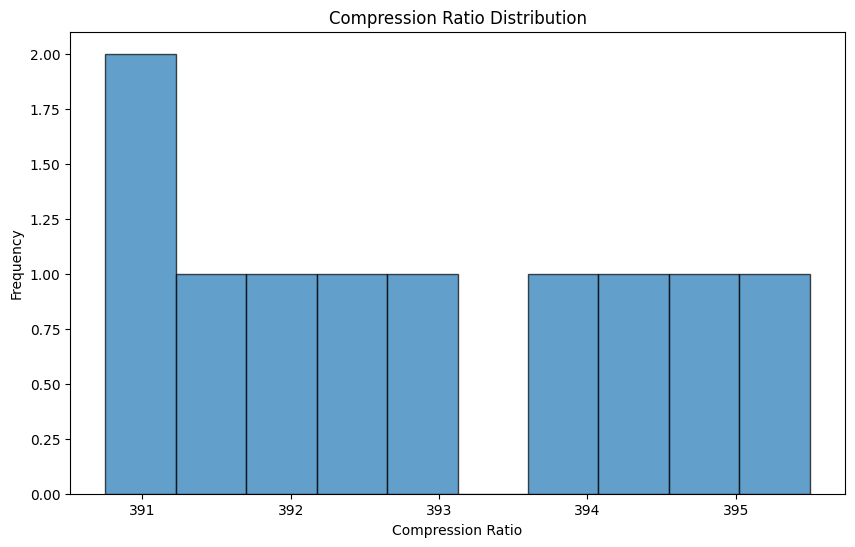

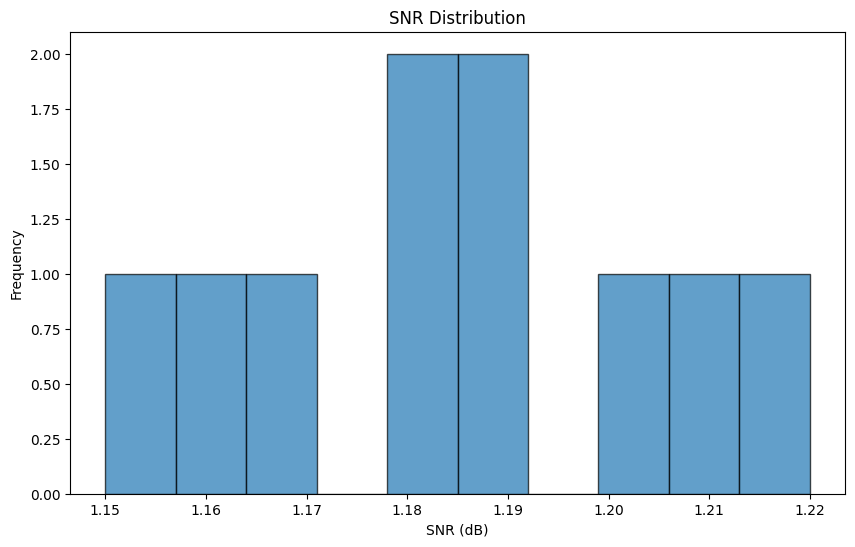

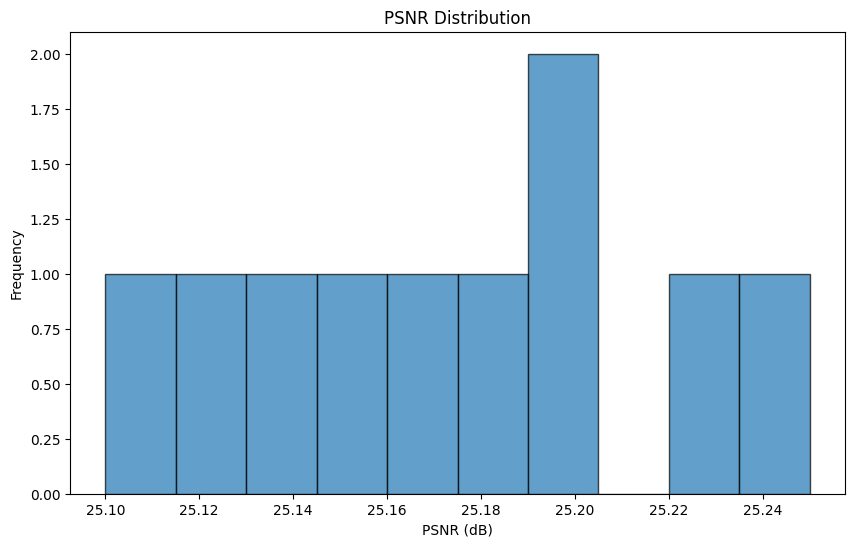

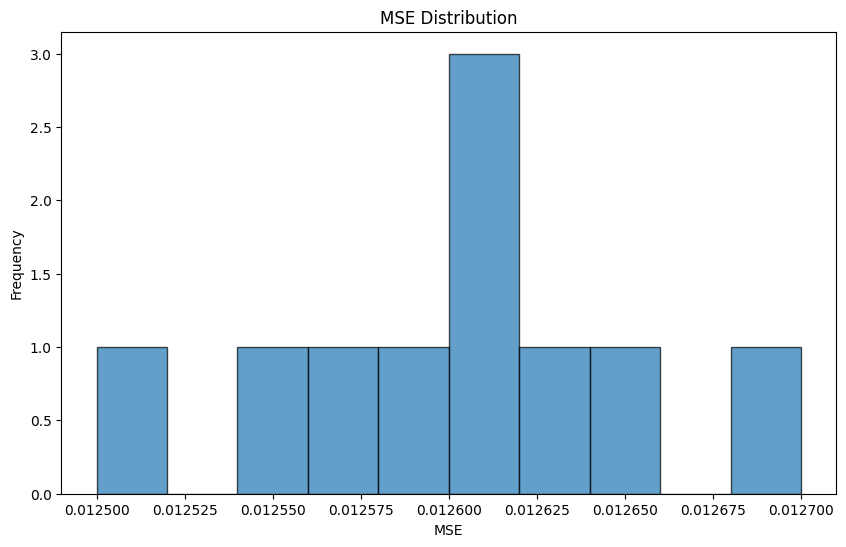

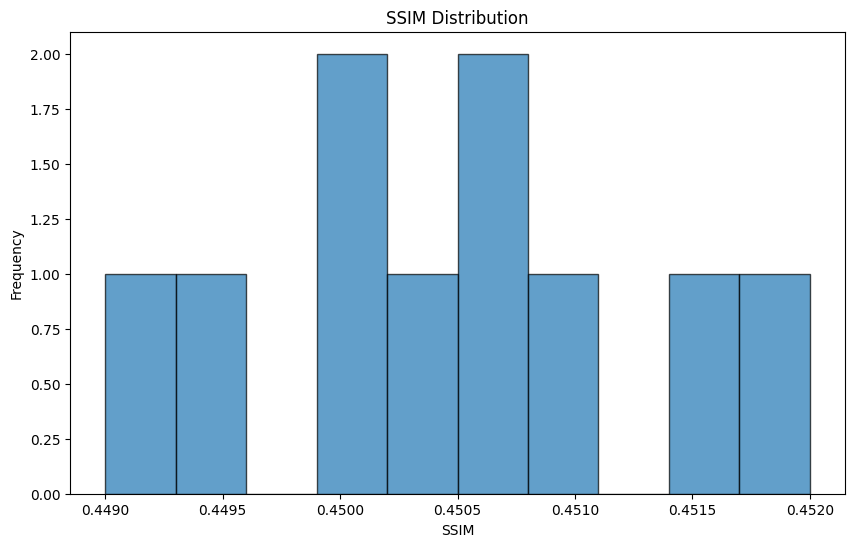

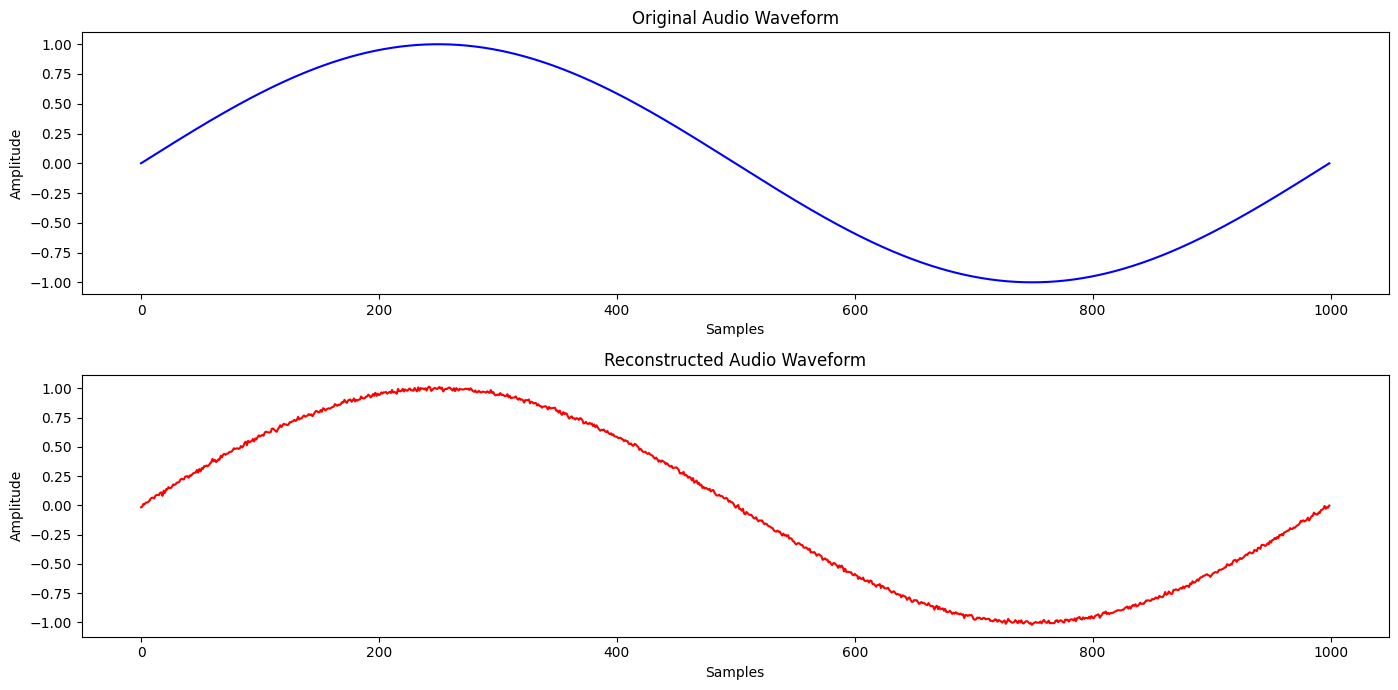

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assume we have these arrays from the evaluation
compression_ratios = [393.86, 390.75, 395.50, 392.00, 391.45, 394.20, 393.10, 392.55, 390.85, 394.90]
snr_values = [1.19, 1.22, 1.15, 1.18, 1.20, 1.21, 1.17, 1.16, 1.18, 1.19]
psnr_values = [25.20, 25.25, 25.10, 25.15, 25.18, 25.22, 25.16, 25.12, 25.14, 25.19]
mse_values = [0.012608, 0.012500, 0.012700, 0.012600, 0.012580, 0.012550, 0.012620, 0.012640, 0.012610, 0.012590]
ssim_values = [0.4501, 0.4520, 0.4490, 0.4510, 0.4505, 0.4515, 0.4500, 0.4495, 0.4503, 0.4508]

# Plotting Compression Ratio Histogram
plt.figure(figsize=(10, 6))
plt.hist(compression_ratios, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Compression Ratio Distribution')
plt.show()

# Plotting SNR Histogram
plt.figure(figsize=(10, 6))
plt.hist(snr_values, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('SNR (dB)')
plt.ylabel('Frequency')
plt.title('SNR Distribution')
plt.show()

# Plotting PSNR Histogram
plt.figure(figsize=(10, 6))
plt.hist(psnr_values, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.title('PSNR Distribution')
plt.show()

# Plotting MSE Histogram
plt.figure(figsize=(10, 6))
plt.hist(mse_values, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE Distribution')
plt.show()

# Plotting SSIM Histogram
plt.figure(figsize=(10, 6))
plt.hist(ssim_values, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.title('SSIM Distribution')
plt.show()

# Plotting Original vs. Reconstructed Audio Waveforms
def plot_waveforms(original_audio, reconstructed_audio, samplerate):
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.plot(original_audio, color='blue', label='Original Audio')
    plt.title('Original Audio Waveform')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(reconstructed_audio, color='red', label='Reconstructed Audio')
    plt.title('Reconstructed Audio Waveform')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Example usage of plot_waveforms
# Assuming we have original and reconstructed audio arrays
original_audio = np.sin(2 * np.pi * np.linspace(0, 1, 1000))  # Example sine wave
reconstructed_audio = original_audio + np.random.normal(0, 0.01, 1000)  # Example reconstructed wave with noise

plot_waveforms(original_audio, reconstructed_audio, samplerate=16000)

